# TFG hateval2019

In [1]:
# some imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Python ≥3.6 is required
import sys
assert sys.version_info >= (3, 6)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
import random

seed_val = 42
np.random.seed(seed_val)
random.seed(seed_val)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rc('font', size=12) 
plt.rc('figure', figsize = (12, 5))

# Settings for the visualizations
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

import pandas as pd
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)


from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
english_train = pd.read_csv('./hateval2019/hateval2019_en_train.csv',index_col=0)
english_dev = pd.read_csv('./hateval2019/hateval2019_en_dev.csv',index_col=0)
english_test = pd.read_csv('./hateval2019/hateval2019_en_test.csv',index_col=0)

spanish_train = pd.read_csv('./hateval2019/hateval2019_es_train.csv',index_col=0)
spanish_dev = pd.read_csv('./hateval2019/hateval2019_es_dev.csv',index_col=0)
spanish_test = pd.read_csv('./hateval2019/hateval2019_es_test.csv',index_col=0)

In [3]:
print(english_train.shape, english_dev.shape, english_test.shape)
print(spanish_train.shape, spanish_dev.shape, spanish_test.shape)

(9000, 4) (1000, 4) (3000, 4)
(4500, 4) (500, 4) (1600, 4)


In [4]:
print(english_test.head())
print(spanish_train.head())

                                                    text  HS  TR  AG
id                                                                  
34243  @local1025 @njdotcom @GovMurphy Oh, I could ha...   0   0   0
30593  Several of the wild fires in #california and #...   0   0   0
31427  @JudicialWatch My question is how do you reset...   0   0   0
31694  #Europe, you've got a problem!   We must hurry...   1   0   0
31865  This is outrageous! #StopIllegalImmigration  #...   1   0   0
                                                    text  HS  TR  AG
id                                                                  
20001  Easyjet quiere duplicar el número de mujeres p...   1   0   0
20002  El gobierno debe crear un control estricto de ...   1   0   0
20003  Yo veo a mujeres destruidas por acoso laboral ...   0   0   0
20004  — Yo soy respetuoso con los demás, sólamente l...   0   0   0
20007  Antonio Caballero y como ser de mal gusto e ig...   0   0   0


## Basic statistical analysis

In [5]:
def plot_top_barchart(text, just_stopwords=True, k=10):
    """Plots a barchart of the `k` most common words in a corpus. 
    Depending on the option `just_stopwords` it will count the stopwords
    or the rest.
    """
    stop = set(stopwords.words('english'))
    
    new = text.str.split().values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word,count in most:
        if len(x) >= k:
            break
        if just_stopwords ^ (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)
    
def plot_top_ngrams_barchart(text, n=2, k=10):
    """Plots a barchart of the `k` most common n-grams words in a corpus. 
    """
    new = text.str.split().values.tolist()
    corpus = [word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:k]

    top_n_bigrams = _get_top_ngram(text,n)[:k]
    x,y = map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    
    
def print_distribution_features(data):
    """Prints feature distribution of the dataset hateval2019.
    TR and AG are always dependent on HS being `True`. As checked on the last line.
    """
    print("Distribution of features:")
    print(f"HS: {100 * np.sum(data['HS'] == True) / data.shape[0]}%")
    print(f"HS -> TR: {100 * np.sum((data['HS'] == True) & (data['TR'] == True)) / np.sum(data['HS'] == True)}%")
    print(f"HS -> AG: {100 * np.sum((data['HS'] == True) & (data['AG'] == True)) / np.sum(data['HS'] == True)}%")
    print(f"HS -> TR & AG: {100 * np.sum((data['HS'] == True) & (data['TR'] == True) & (data['AG'] == True)) / np.sum(data['HS'] == True)}%")
    print(f"!HS & (TR | AG): {100 * np.sum((data['HS'] == False) & ((data['TR'] == True) | (data['AG'] == True))) / data.shape[0]}%")


def _aux_print_distribution_search_pattern(data, pattern, k=10):
    """Auxiliar method that prints the information related to a specific search.
    Such as the mentions of this pattern in each tweet, the number of unique mentions,
    the `k` most common words that fulfill the pattern.
    
    `pattern` has to be a regex to be searched and `data` has to be from the hateval2019
    dataset.
    """
    data_text = data["text"].str.findall(pattern)
    n_data = data_text.map(lambda x: len(x))
    print(f"Number of mentions per tweet (MIN, MEAN, MAX): ({n_data.min()}, {n_data.mean()}, {n_data.max()})")
    n_data_users = data_text.map(lambda x: len(x) > 0)
    print(f"Number of tweets that contain a mention: {n_data_users.mean()}")
    
    print("Most Common mentions:")
    data_1d = data_text.explode()
    most_common_data = pd.DataFrame({"Mention": data_1d.value_counts()[:k].index, "Count": data_1d.value_counts()[:k].values}).set_index("Mention")
    
    for feature in ["HS", "TR", "AG"]: # Calculates percentage the ratio of all features of the tweets that mention the data.
        most_common_data[feature] = most_common_data.index.map(lambda mention: np.mean(data.loc[data_1d[data_1d == mention].index][feature]))
    for feature in ["TR", "AG"]: # Changes the percentage of the two other features to represent if HS is True what is the percentage ratio.
        # Avoids divistion by zero, by letting be zero. As checked it will always be 0/0, so we can ignore it.
        most_common_data[feature] = np.divide(most_common_data[feature], most_common_data["HS"], out=np.zeros(most_common_data.shape[0]), where=most_common_data["HS"]!=0)
        most_common_data.rename(columns={feature:f"HS -> {feature}"}, inplace=True)

    print(most_common_data) 
    return most_common_data
    

def print_twitter_information(data):
    """Prints information related with twitter features: mentions to users and hashtags.
    Also prints the most common links.
    (trening topics).
    """
    print("\nUsers:")
    _aux_print_distribution_search_pattern(data, r"@\w*")
    
    print("\nHashtags:")
    _aux_print_distribution_search_pattern(data, r"#\w*")
    
    print("\nLinks:")
    _aux_print_distribution_search_pattern(data, r"https?\S*")
    
    print("\nNon-ascii:")
    _aux_print_distribution_search_pattern(data, r"[^\x00-\x7F]")
    
def print_tweet_characteristics(data):
    """Prints general information about the string corpus.
    """
    print("\nTweets: (MIN, MEAN, MAX)")
    n_characters = data["text"].str.len()
    print(f"Number of characters: ({n_characters.min()}, {n_characters.mean()}, {n_characters.max()})")
    n_words = data["text"].str.split().map(lambda x: len(x))
    print(f"Mean of Number of words: ({n_words.min()}, {n_words.mean()}, {n_words.max()})")
    avg_word_lenght = data["text"].str.split().map(lambda x : np.mean([len(i) for i in x]))
    print(f"Mean of Avarage word lenght: ({avg_word_lenght.min()}, {avg_word_lenght.mean()}, {avg_word_lenght.max()})")
    
    plt.figure(1)
    plt.subplot(131)

    # Characters
    n_characters.hist()
    plt.title("Number of characters")
    plt.subplot(132)
    # Words
    n_words.hist()
    plt.title("Number of words")
    plt.subplot(133)
    # Mean Characters in Words
    avg_word_lenght.hist()
    plt.title("Avarage word lenght")
    plt.show()
    

def basic_statistics_plot(orig_data, HS=None, TR=None, AG=None):
    """Method that prints and plots basic information about the dataset.
    `HS`, `TR`, `AG` will allow to filter by specific values of the features.
    """
    true_array = np.ones(orig_data.shape[0], dtype=bool)
    
    data = orig_data.loc[(true_array if HS is None else orig_data["HS"] == HS) &
                (true_array if TR is None else orig_data["TR"] == TR) &
                (true_array if AG is None else orig_data["AG"] == AG)].copy()
    
    data["text"] = data["text"].apply(lambda x: x.lower())
    
    print_distribution_features(data) # Basic feature information
    print_twitter_information(data) # Unique characteristics of tweets (like users and hashtags)
    print_tweet_characteristics(data) # Basic text information

    # Most common words
    plt.figure(2)
    plt.subplot(121)
    plot_top_barchart(data["text"], just_stopwords=True)
    plt.title("Most common stopwords")
    plt.subplot(122)
    plot_top_barchart(data["text"], just_stopwords=False)
    plt.title("Most common non-stopwords")
    
    # Most common n-grams
    plt.figure(3)
    plt.subplot(121)
    plot_top_ngrams_barchart(data["text"], n=2)
    plt.title("Most common bigrams")
    plt.subplot(122)
    plot_top_ngrams_barchart(data["text"], n=3)
    plt.title("Most common trigrams")
    plt.show()

English:
Distribution of features:
HS: 42.07692307692308%
HS -> TR: 38.19012797074954%
HS -> AG: 43.089579524680076%
HS -> TR & AG: 13.875685557586838%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.7923846153846154, 42)
Number of tweets that contain a mention: 0.4179230769230769
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@realdonaldtrump    549  0.553734  0.101974  0.608553
@potus              189  0.566138  0.093458  0.579439
@isupport_israel    105  0.580952  0.131148  0.442623
@anncoulter         102  0.627451  0.843750  0.250000
@youtube             71  0.309859  0.090909  0.454545
@housegop            66  0.878788  0.034483  0.672414
@foxnews             65  0.538462  0.200000  0.400000
@                    60  0.416667  0.480000  0.400000
@refugees            59  0.016949  0.000000  0.000000
@realjameswoods      58  0.293103  0.235294  0.529412

Hashtags:
Nu

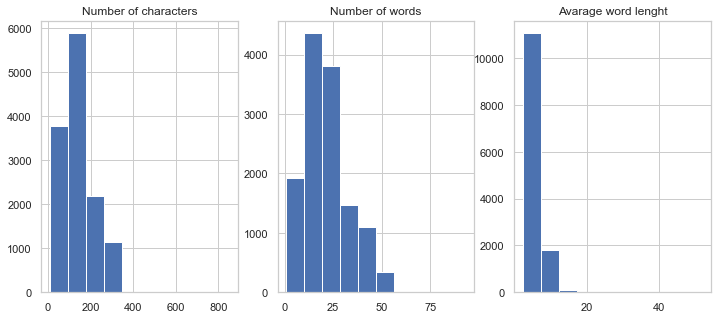

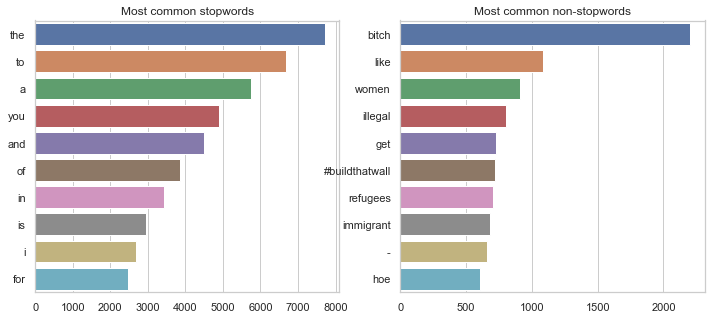

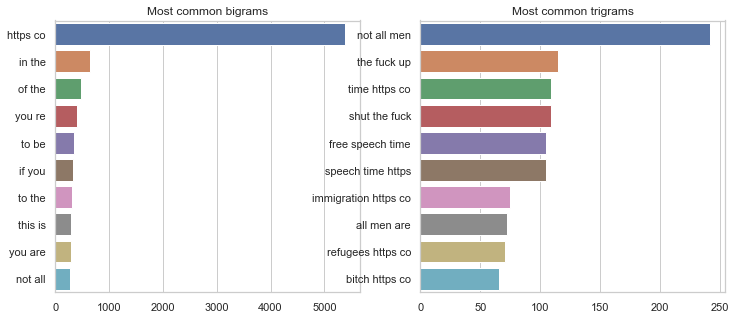

In [27]:
print("English:")
basic_statistics_plot(pd.concat([english_train, english_dev, english_test]))

Spanish:
Distribution of features:
HS: 41.5%
HS -> TR: 61.66484118291347%
HS -> AG: 78.56882073749544%
HS -> TR & AG: 56.626506024096386%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.7271212121212122, 50)
Number of tweets that contain a mention: 0.4637878787878788
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@barbijaputa        104  0.038462  0.750000  0.750000
@sanchezcastejon     65  0.523077  0.088235  0.823529
@guardiacivil        39  0.358974  0.142857  0.500000
@elmundoes           28  0.428571  0.000000  0.583333
@youtube             25  0.120000  1.000000  1.000000
@anaisbernal         22  0.000000  0.000000  0.000000
@zurine3             19  0.000000  0.000000  0.000000
@interiorgob         17  0.470588  0.125000  0.500000
@policia             17  0.470588  0.250000  0.875000
@relatofeminista     17  0.176471  0.333333  0.333333

Hashtags:
Number of mentio

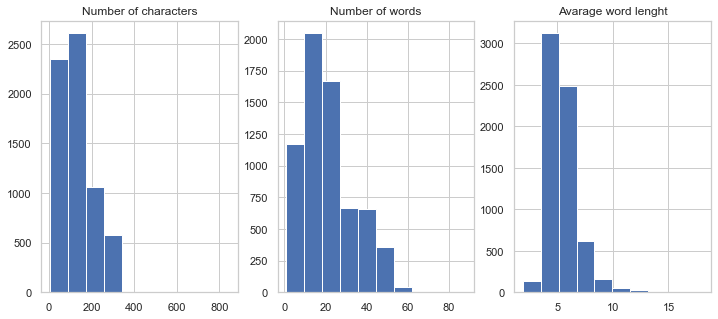

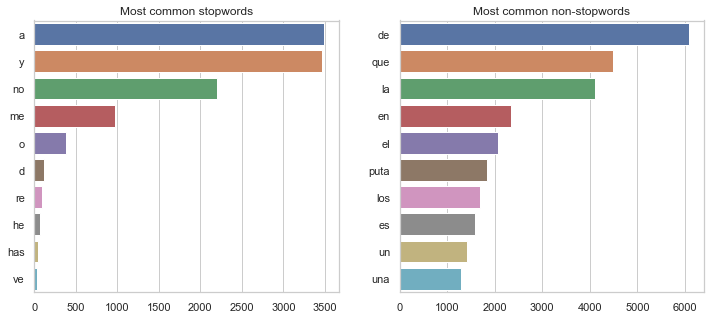

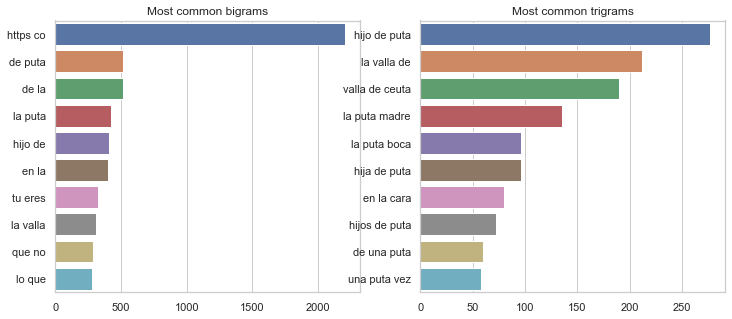

In [28]:
print("Spanish:")
basic_statistics_plot(pd.concat([spanish_train, spanish_dev, spanish_test]))

TRAIN:

Distribution of features:
HS: 42.03333333333333%
HS -> TR: 35.448057097541636%
HS -> AG: 41.210679355009255%
HS -> TR & AG: 12.344699973565953%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.6873333333333334, 20)
Number of tweets that contain a mention: 0.3913333333333333
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@realdonaldtrump    281  0.758007  0.122066  0.586854
@potus               93  0.860215  0.125000  0.562500
@isupport_israel     92  0.597826  0.127273  0.436364
@refugees            55  0.000000  0.000000  0.000000
@youtube             53  0.339623  0.111111  0.500000
@anncoulter          41  0.756098  0.741935  0.258065
@mailonline          36  0.527778  0.105263  0.368421
@tyrusmaina          35  0.000000  0.000000  0.000000
@                    35  0.485714  0.470588  0.411765
@housegop            32  0.906250  0.034483  0.655172

Hashtags:
Nu

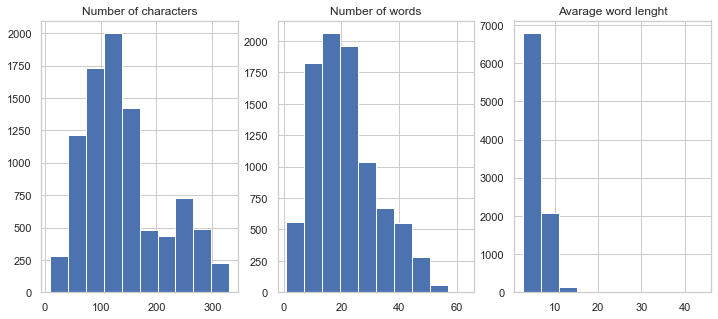

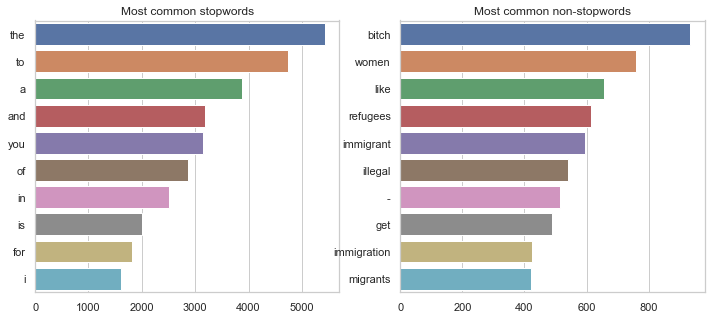

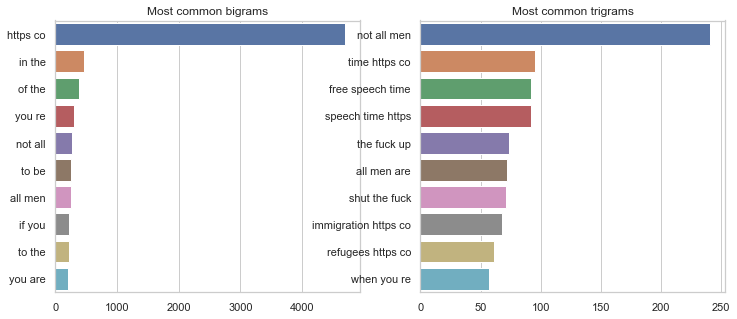



TRAIN with HS:

Distribution of features:
HS: 100.0%
HS -> TR: 35.448057097541636%
HS -> AG: 41.210679355009255%
HS -> TR & AG: 12.344699973565953%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.7869415807560137, 20)
Number of tweets that contain a mention: 0.4557229711868887
Most Common mentions:
                  Count   HS  HS -> TR  HS -> AG
Mention                                         
@realdonaldtrump    213  1.0  0.122066  0.586854
@potus               80  1.0  0.125000  0.562500
@isupport_israel     55  1.0  0.127273  0.436364
@anncoulter          31  1.0  0.741935  0.258065
@housegop            29  1.0  0.034483  0.655172
@senategop           23  1.0  0.043478  0.565217
@foxnews             21  1.0  0.333333  0.333333
@icegov              20  1.0  0.150000  0.650000
@mailonline          19  1.0  0.105263  0.368421
@speakerryan         18  1.0  0.000000  0.666667

Hashtags:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 1.13111287338

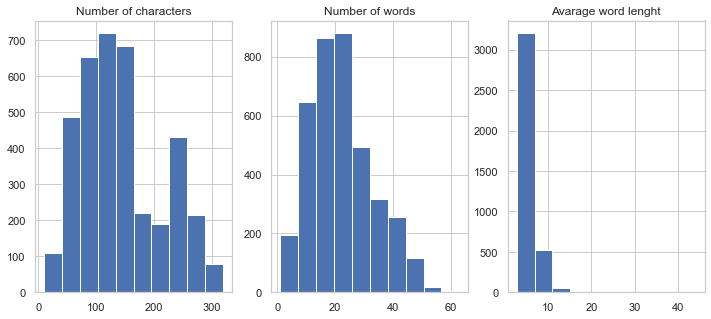

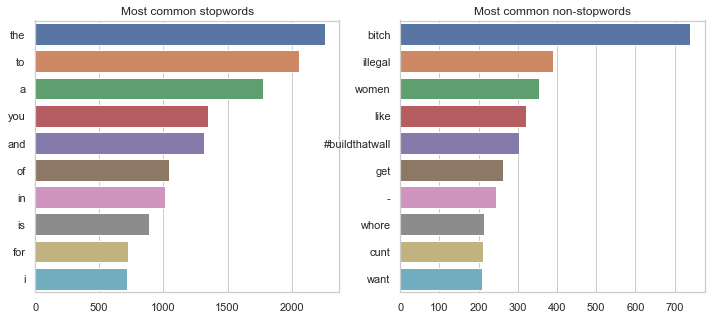

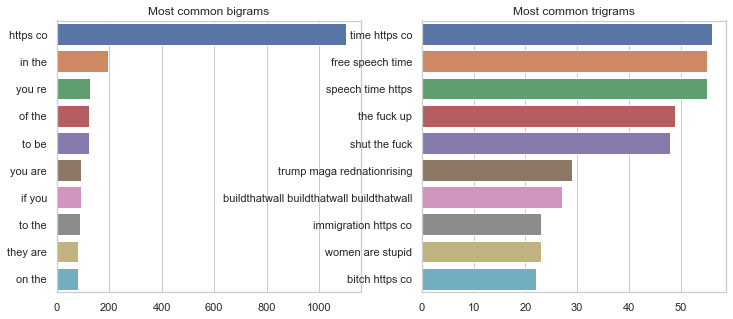



DEV:

Distribution of features:
HS: 42.7%
HS -> TR: 51.288056206088996%
HS -> AG: 47.7751756440281%
HS -> TR & AG: 25.526932084309134%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.922, 42)
Number of tweets that contain a mention: 0.504
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@anncoulter          47  0.680851  0.968750  0.218750
@realdonaldtrump     35  0.571429  0.150000  0.550000
@isupport_israel     13  0.461538  0.166667  0.500000
@potus               11  0.909091  0.000000  0.600000
@corybooker           9  0.555556  1.000000  0.000000
@senkamalaharris      9  1.000000  1.000000  0.111111
@youtube              9  0.111111  0.000000  0.000000
@donaldjtrumpjr       7  0.857143  0.833333  0.166667
@housegop             6  1.000000  0.000000  1.000000
@bensasse             5  0.000000  0.000000  0.000000

Hashtags:
Number of mentions per tweet (MIN, MEAN, MA

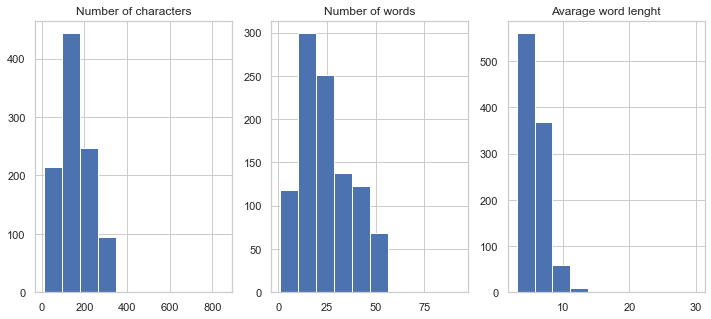

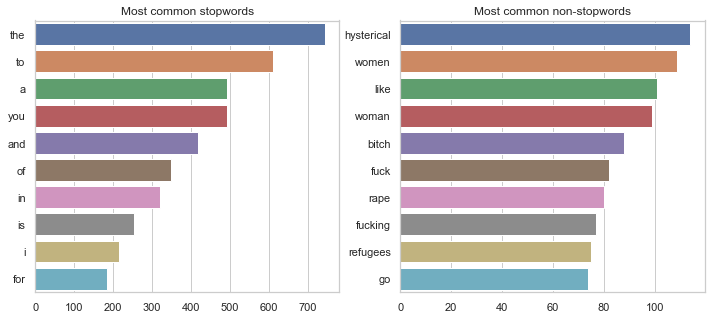

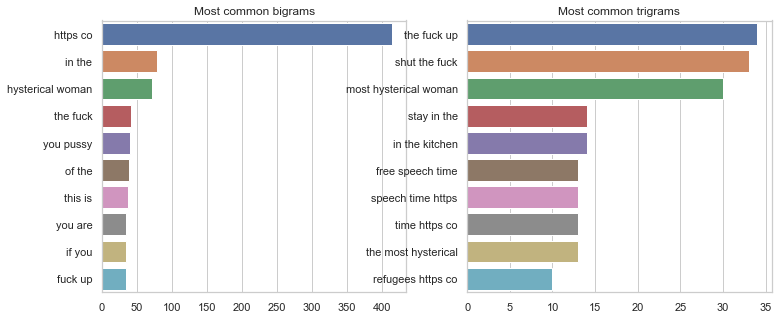



TEST:

Distribution of features:
HS: 42.0%
HS -> TR: 41.98412698412698%
HS -> AG: 47.142857142857146%
HS -> TR & AG: 14.523809523809524%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 1.0643333333333334, 40)
Number of tweets that contain a mention: 0.469
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@realdonaldtrump    233  0.304721  0.028169  0.690141
@potus               85  0.200000  0.000000  0.647059
@realjameswoods      41  0.073171  0.000000  0.333333
@foxnews             32  0.312500  0.000000  0.600000
@speakerryan         29  0.379310  0.090909  0.454545
@housegop            28  0.821429  0.043478  0.608696
@icegov              23  0.739130  0.000000  0.764706
@gop                 22  0.454545  0.000000  0.500000
@senategop           22  0.818182  0.000000  0.722222
@                    20  0.300000  0.333333  0.333333

Hashtags:
Number of mentions per tweet

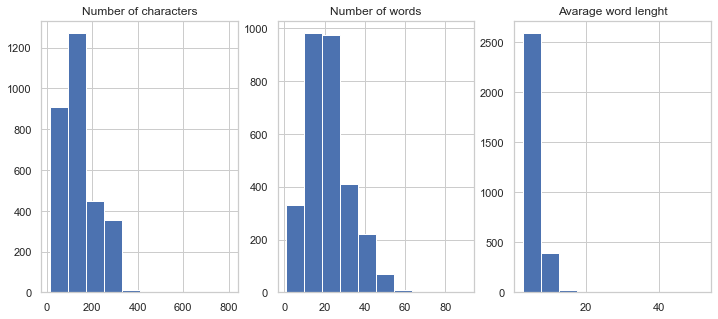

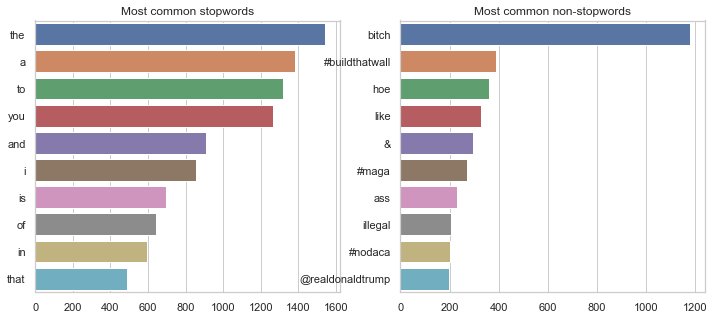

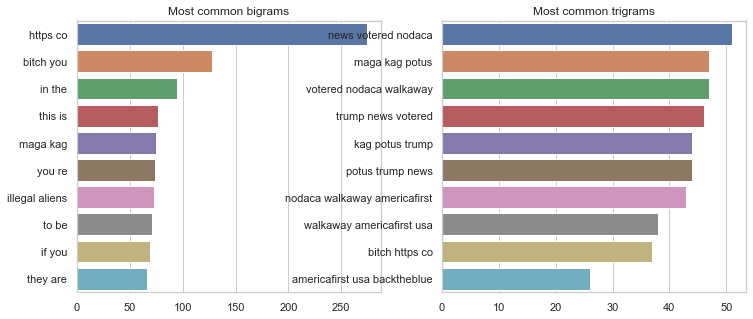

In [29]:
print("TRAIN:\n")
basic_statistics_plot(english_train)
print("\n\nTRAIN with HS:\n")
basic_statistics_plot(english_train, HS=True)
print("\n\nDEV:\n")
basic_statistics_plot(english_dev)
print("\n\nTEST:\n")
basic_statistics_plot(english_test)

TRAIN:

Distribution of features:
HS: 41.266666666666666%
HS -> TR: 60.796984383414106%
HS -> AG: 80.88314485729671%
HS -> TR & AG: 56.70436187399031%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.6551111111111111, 16)
Number of tweets that contain a mention: 0.4351111111111111
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@sanchezcastejon     24  0.708333  0.117647  0.941176
@youtube             23  0.043478  1.000000  1.000000
@barbijaputa         21  0.142857  0.666667  0.666667
@anaisbernal         15  0.000000  0.000000  0.000000
@zurine3             13  0.000000  0.000000  0.000000
@leticiadolera       12  0.000000  0.000000  0.000000
@relatofeminista     12  0.166667  0.500000  0.500000
@_eckoyg             11  0.000000  0.000000  0.000000
@irantzuvarela       11  0.090909  0.000000  0.000000
@                    10  0.400000  0.250000  1.000000

Hashtags:
Num

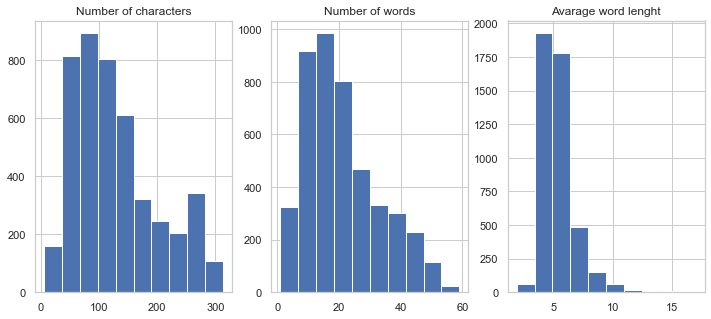

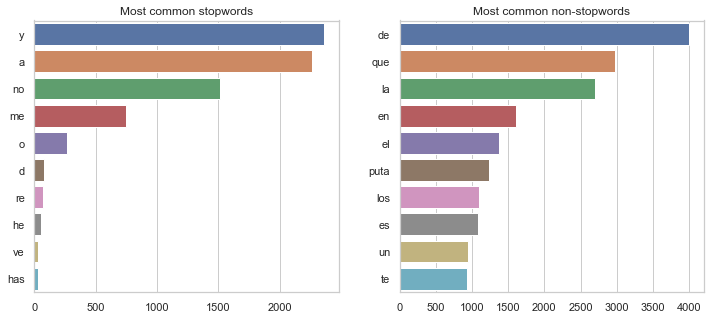

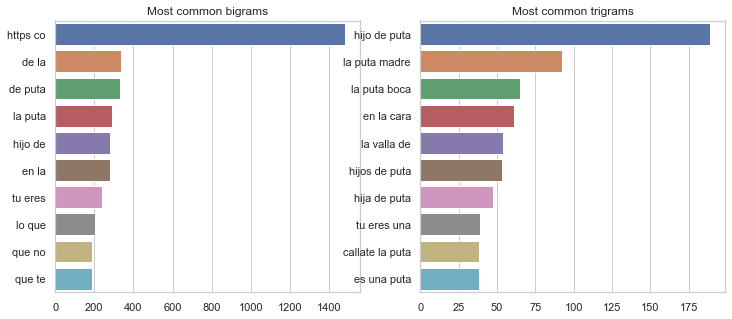



TRAIN with HS:

Distribution of features:
HS: 100.0%
HS -> TR: 60.796984383414106%
HS -> AG: 80.88314485729671%
HS -> TR & AG: 56.70436187399031%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.6806677436725902, 8)
Number of tweets that contain a mention: 0.464728056004308
Most Common mentions:
                  Count   HS  HS -> TR  HS -> AG
Mention                                         
@sanchezcastejon     17  1.0  0.117647  0.941176
@lortegadiaz          7  1.0  1.000000  1.000000
@nicolasmaduro        6  1.0  0.333333  0.833333
@lopezdoriga          6  1.0  1.000000  1.000000
@adacolau             5  1.0  0.200000  1.000000
@beeluarzola          5  1.0  1.000000  1.000000
@drodriguezven        5  1.0  0.800000  1.000000
@elperiodico          4  1.0  0.000000  0.750000
@policia              4  1.0  0.500000  1.000000
@sebastianpinera      4  1.0  0.000000  0.750000

Hashtags:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.121163166397415

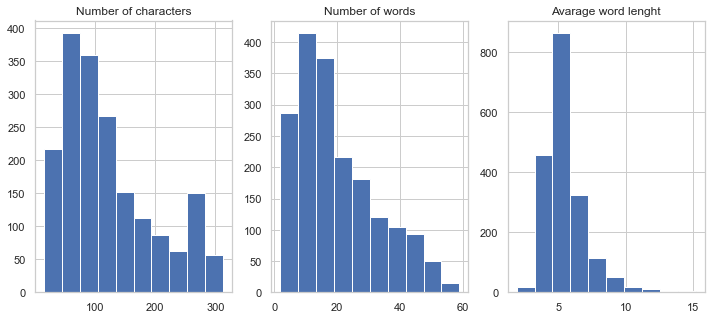

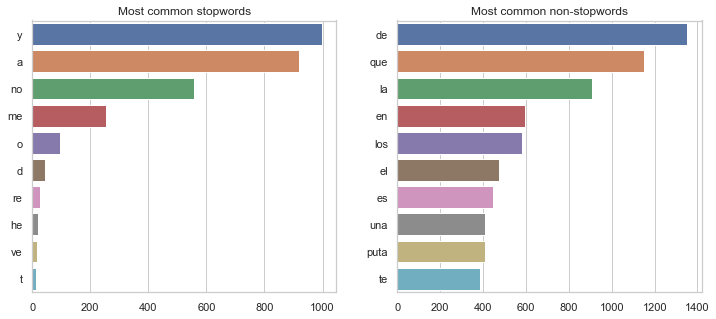

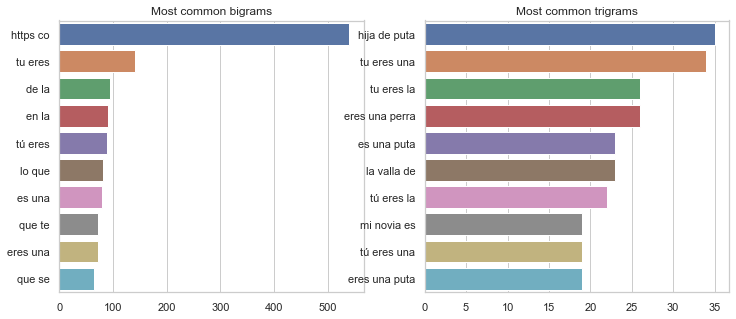



DEV:

Distribution of features:
HS: 44.4%
HS -> TR: 61.711711711711715%
HS -> AG: 79.27927927927928%
HS -> TR & AG: 57.207207207207205%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.654, 5)
Number of tweets that contain a mention: 0.444
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@zurine3              4  0.000000       0.0  0.000000
@nicolasmaduro        3  0.000000       0.0  0.000000
@relatofeminista      3  0.333333       0.0  0.000000
@elmundoes            3  1.000000       0.0  0.666667
@sanchezcastejon      3  0.333333       0.0  1.000000
@guardiacivil         3  0.333333       0.0  1.000000
@pablocasado_         2  0.500000       0.0  1.000000
@barbijaputa          2  0.000000       0.0  0.000000
@dalasreview          2  0.000000       0.0  0.000000
@lasextatv            2  0.500000       0.0  0.000000

Hashtags:
Number of mentions per tweet (MIN, MEAN, MA

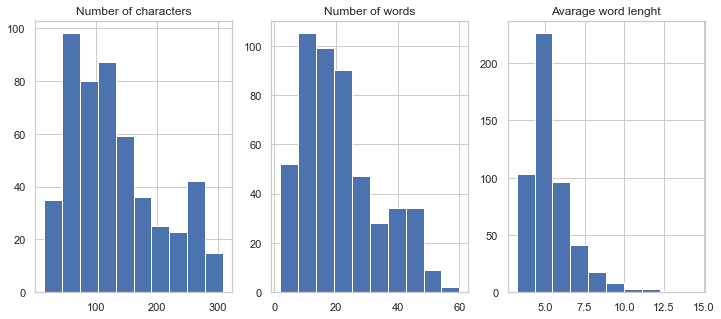

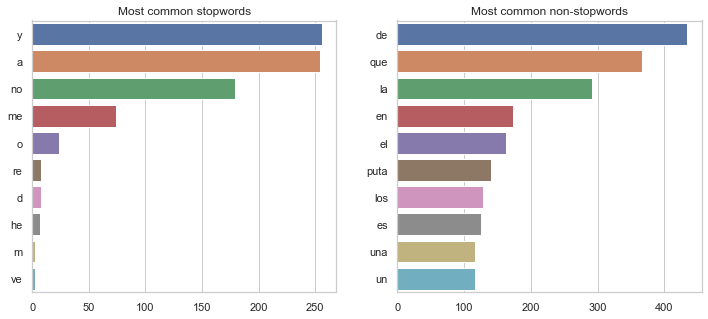

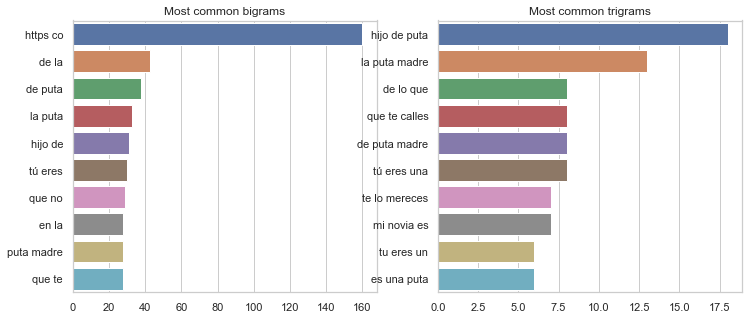



TEST:

Distribution of features:
HS: 41.25%
HS -> TR: 64.0909090909091%
HS -> AG: 71.81818181818181%
HS -> TR & AG: 56.21212121212121%
!HS & (TR | AG): 0.0%

Users:
Number of mentions per tweet (MIN, MEAN, MAX): (0, 0.9525, 50)
Number of tweets that contain a mention: 0.550625
Most Common mentions:
                  Count        HS  HS -> TR  HS -> AG
Mention                                              
@barbijaputa         81  0.012346  1.000000  1.000000
@sanchezcastejon     38  0.421053  0.062500  0.687500
@guardiacivil        31  0.290323  0.000000  0.222222
@elmundoes           18  0.333333  0.000000  0.500000
@interiorgob         13  0.461538  0.000000  0.333333
@psoe                11  0.454545  0.000000  0.800000
@abc_es              10  0.300000  0.000000  1.000000
@elisacarrio          9  1.000000  1.000000  1.000000
@updayesp             7  0.571429  0.000000  0.500000
@vox_es               7  1.000000  0.285714  0.714286

Hashtags:
Number of mentions per tweet (MIN, MEAN

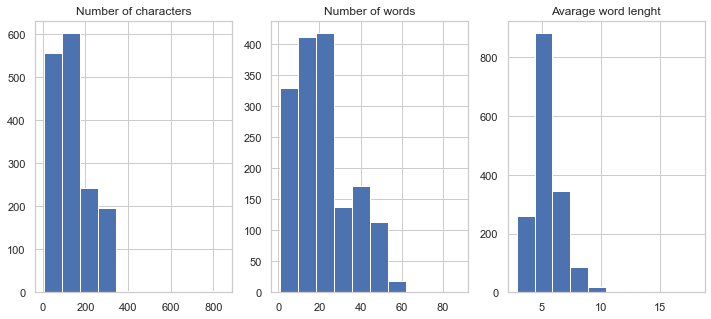

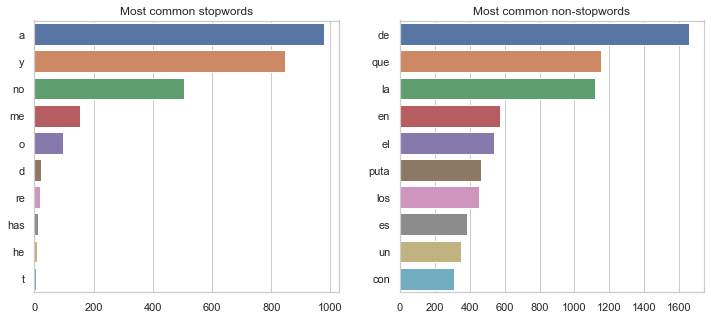

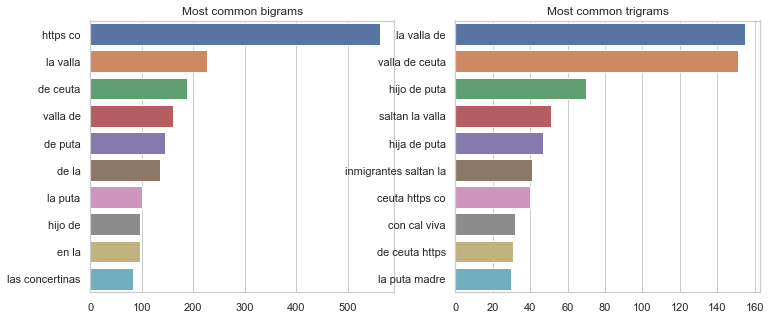

In [30]:
print("TRAIN:\n")
basic_statistics_plot(spanish_train)
print("\n\nTRAIN with HS:\n")
basic_statistics_plot(spanish_train, HS=True)
print("\n\nDEV:\n")
basic_statistics_plot(spanish_dev)
print("\n\nTEST:\n")
basic_statistics_plot(spanish_test)

## Tf-Idf
### Preprocessing

DONE:

- Remove links
- Lowercase all characters
- Remove emojis (or replaced)
- Remove stopwords
- Correct spelling mistakes
- Remove numbers (or replace by word "number")
- Replace ”&” for "and"
- Standardize blank spaces
- Normalize contractions
- Lemmatization
- Substitution of abbreviations

TODO: 

- Remove punctuation (Spanish)

In [6]:
from datetime import datetime, timedelta

def init_print_progress(n, k=10, measure_remaining_time=True, measure_avarage_time=True):
    """Inicializes the auxialiar `_print_progress()` establishing the behaviour of when
    and what should be printed.
    
    Parameters
    ----------
    n: int
        Number of iterations the auxiliar method will be called.
    k: int, default=10
        Number of iterations of when the printed data will be updated.
    measure_remaining_time: bool, default=True
        If the printed progress should display the remaining time.
    measure_avarage_time: bool, default=True
        If the remaining time should be calculated using an avarage.
        Recomended if the task load should be similar.
    """
    _print_progress._i = 1 # Number of iterations done
    _print_progress._k = k # Module of when the print will be called
    _print_progress._n = n # Total iterations to be complated
    
    _print_progress._measure_remaining_time = measure_remaining_time # If time should be tracked
    _print_progress._measure_avarage_time = measure_avarage_time # If an avarage should be used
    if measure_remaining_time:
        _print_progress._datetime = datetime.now() # Time of completion of last k iterations
        _print_progress.avargetime = timedelta() # Avarage time of the k iterations
    
def _print_progress():
    """Auxiliar method that will track progress of a fucntion. Should be called each time
    an iterations is done. Before starting the tracking, the function `init_print_progress()`
    should be called once.
    """
    _i, _k, _n = _print_progress._i, _print_progress._k, _print_progress._n
    if _i % _k == 0 or _i == _n: #Every k iterations prints or it's the last iteration
        _measure_remaining_time = _print_progress._measure_remaining_time
        if _measure_remaining_time:
            next_datetime = datetime.now()
            diff_time = next_datetime - _print_progress._datetime # Time elapsed between now and the previous k iteration
            if _print_progress._measure_remaining_time:
                _print_progress.avargetime = (_print_progress.avargetime * (_i//_k - 1) + diff_time) / (_i//_k) # Updates avarge time by adding the new elapsed time to the avarage
            else:
                _print_progress.avargetime = diff_time # Avarage time isn't tracked
            time_remaining = ((_print_progress.avargetime) / _k * (_n - _i)).total_seconds() #Calculates the time remaining
            _print_progress._datetime = next_datetime # Upadates the last time
            
        print(" "*100, end='\r') # Cleans the output
        print(f"{_i}/{_n} ({round(100*_i/_n, 2)}%)", end='') # Prints the current percentage of completion
        # Prints the calculated remaining time if specified in the inicialization. Also last iteration ends with '\n' leaving the percentage completion
        print(f" [time remaining: {int(time_remaining//3600)}:{int(time_remaining/60%60):02d}:{int(time_remaining%60):02d}]" if _measure_remaining_time else "", end='\r' if _i < _n else '\n')
    _print_progress._i += 1 # Increments the number of iterations that had happened

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import re
from spellchecker import SpellChecker
from pycontractions import Contractions
import json
import os.path
import pickle

# TODO: Comprovar si: nltk.download('wordnet')


def load_dictonaries():
    """Loads the data inside the json files of all dictonaries.
    This way we avoid reconstructing the dictonary each instance.
    """
    with open('./data/simple_emojis.json') as f:
        replace_emojis.simple_emojis = json.load(f)
        
    with open('./data/complex_emojis.json') as f:
        replace_emojis.complex_emojis = json.load(f)
        
    with open('./data/abbreviations.json') as f:
        replace_abbreviations.abbreviations = json.load(f) 

def replace_emojis(text, lenguage='en'):
    """Replaces all emojis with the meaning in the dictionary. Extra 
    spaces are added to both sides to avoid case where a word or 
    another emoji aren't separated.
    """
    simple_emojis = replace_emojis.simple_emojis
    for emoji, meaning in simple_emojis.items():
        text = text.replace(emoji, f" {meaning[lenguage]} ")
        
    complex_emojis = replace_emojis.complex_emojis
    for emoji, meaning in complex_emojis.items():
        text = text.replace(emoji, f" {meaning[lenguage]} ")
        
    return text

def replace_abbreviations(text, lenguage='en'):
    """Replaces all exact abbreviations with the meaning in the dictionary.
    Will try to replace exact match of the abbreviation if it's translated
    in the meaning dictonary.
    """
    abbreviations = replace_abbreviations.abbreviations 
    for abbreviation, meaning in abbreviations.items():
        if lenguage in meaning:
            text = re.sub(r"\b" + abbreviation + r"\b", meaning[lenguage], text)

    return text

def direct_replacement(data):
    """
    Performs replacement or removal of diffent parts of text series. Currently does:
        - Lowercase
        - Standerization of contractions and other characters
        - Link removal
        - Digits removal
        - Emoji replacement with it's meaning or removal in case it's not found
    """
    def _replacement(text):
        # Lowercase and replace & and Standerize contractions and other special characters
        text = text.replace("’", "'").replace("‘", "'").replace("…", "...").replace("”", "\"\"").replace("“", "\"\"").lower()
        
        # Remove links
        text = re.sub(r"https?\S*", "", text)
        
        # Remove digits
        text = re.sub(r"\d+", "", text)
        
        # Replace emojis
        text = replace_emojis(text)
        
        # Remove emojis in case they where not replaced
        regrex_pattern = re.compile(pattern = "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags = re.UNICODE)
        text = regrex_pattern.sub(r'', text)
                          
        # Replace abbreviations
        replace_abbreviations(text)
        
        
        return text

    load_dictonaries()
    return data.apply(lambda text: _replacement(text))

def expand_contractions(data):
    """
    Expand contractions of all the dataset through the context using a deep learning model.
    Currently it's using the model of word2vec.
    """
    # Download link: https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
    cont = Contractions('./models/GoogleNews-vectors-negative300.bin')
    cont.load_models()
    
    data_expanded = list(cont.expand_texts(data, precise=False))
    
    return pd.Series(data_expanded, index=data.index, dtype=data.dtype, name=data.name)
    

def tokenization_text(text):
    """
    Transforms the text into a serie of tokens that will contain only words, hashtags or users.
    Also corrects the text using Levenshtein Distance of 2. Then, lemmatises the tokens and 
    removes the stopwords.
    """
    # Tokenise words without digits while ignoring punctuation, except Users and Hashtags
    tokeniser = RegexpTokenizer(r'[#@]?[^\d\W]+')
    tokens = tokeniser.tokenize(text)
    
    # Corrector with Levenshtein Distance of 2
    spell = SpellChecker(distance=2)
    tokens = [spell.correction(token) for token in tokens]
    
    # Lemmatization 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token, pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    
    _print_progress() # Auxiliar method to track the progress

    return keywords

# Tf-Idf vectorizer
vectorizer = TfidfVectorizer(analyzer=tokenization_text, max_features=3500, max_df=0.65)

# Pipeline to generate the Tf-Idf matrix of the dataset
basic_pipe = Pipeline([
    ('direct_replacement', FunctionTransformer(func=direct_replacement, validate=False)),
    ('expand_contractions', FunctionTransformer(func=expand_contractions, validate=False)),
    ('tfidfVectorizer', vectorizer)
])

### Save and load preprocessing

In [8]:
from scipy import sparse

train_path, dev_path, test_path = "./data/X_train_basic_Atalaya.npz", "./data/X_dev_basic_Atalaya.npz", "./data/X_test_basic_Atalaya.npz"
if not 'is_TfIDF_fitted' in globals(): #Avoids redefinition, so rexecuting cell doesn't rewrite the value
    is_TfIDF_fitted = False

def load_Tfidf_processing(pipe, train_data, data, path, name):
    global is_TfIDF_fitted
    
    if os.path.isfile(path):
        X_basic = sparse.load_npz(path)
        print(f"Preprocessing {name} data loaded succesfully")
    else:
        init_print_progress(train_data.shape[0])
        if data.equals(train_data):
            X_basic = pipe.fit_transform(train_data['text'])
            is_TfIDF_fitted = True
        else:
            if not is_TfIDF_fitted:
                print("Pipe will be fitted first.")
                pipe.fit(train_data['text'])
                is_TfIDF_fitted = True

            init_print_progress(data.shape[0])
            X_basic = pipe.transform(data['text'])

        sparse.save_npz(path, X_basic)
        
    return X_basic

X_basic_train = load_Tfidf_processing(basic_pipe, english_train, english_train, train_path, "train")
X_basic_dev = load_Tfidf_processing(basic_pipe, english_train, english_dev, dev_path, "dev")
X_basic_test = load_Tfidf_processing(basic_pipe, english_train, english_test, test_path, "test")

Preprocessing train data loaded succesfully
Preprocessing dev data loaded succesfully
Preprocessing test data loaded succesfully


In [9]:
from sklearn.preprocessing import StandardScaler

def extra_data(data):
    """Generates extra data from the text. Currently it just counts the number of uppercase letters
    and the number of uppercase words
    """
    uppercase_leters = data.apply(lambda text: sum(1 for c in text if c.isupper()))
    uppercase_words = data.apply(lambda text: sum(1 for word in text.split() if word.isupper()))
    
    return np.c_[(uppercase_leters, uppercase_words)]

extra_pipe = Pipeline([
    ('extra_data', FunctionTransformer(func=extra_data, validate=False)),
    #('standarize', StandardScaler()),
    ('sparse',  FunctionTransformer(func=lambda data: sparse.csr_matrix(data), validate=False))
])

# Calculates the extra data for both train and dev datasets
X_extra_train = extra_pipe.fit_transform(english_train['text'])
X_extra_dev = extra_pipe.transform(english_dev['text'])
X_extra_test = extra_pipe.transform(english_test['text'])

In [10]:
# Joins the Tf-Idf matrix and the extra data
X_train = X_basic_train #sparse.hstack((X_basic_train, X_extra_train))
X_dev = X_basic_dev #sparse.hstack((X_basic_dev, X_extra_dev))
X_test = X_basic_test #sparse.hstack((X_basic_test, X_extra_test))

## Save results

In [11]:
import pandas as pd
import os
from enum import Enum

metadata_file = "./results/metadata.pkl"
dataset_types =  Enum("dataset_types", "train development test")

def save_results(y_pred, index, name, task, lenguage, dataset_type, group=None, description=None, truth=False, filename=None):
    
    path = f"./results/{task}/{lenguage}/{dataset_type.name}{'/' + group if group is not None else ''}/{name if filename is None else filename}.pkl"
    
    directory = "/".join(path.split("/")[:-1])
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    if os.path.exists(metadata_file):
        metadata = pd.read_pickle(metadata_file)
    else:
        metadata = pd.DataFrame({
            "Path": pd.Series([], dtype=str),
            "Name": pd.Series([], dtype=str),
            "Description": pd.Series([], dtype=str),
            "Dataset type": pd.Categorical([], categories=dataset_types, ordered=False),
            "Groud Truth": pd.Series([], dtype=bool),
            "Group": pd.Series([], dtype=str),
            "Task": pd.Series([], dtype=str),
            "Lenguage": pd.Series([], dtype=str),
        }).set_index("Path")
    
    if path in metadata.index:
        metadata = remove_results(path)

    metadata.loc[path] = {"Name": name, "Description": description, "Dataset type": dataset_type, "Groud Truth": truth, "Group": group, "Task": task, "Lenguage": lenguage}
    results = pd.DataFrame({"id": index, "y_pred": y_pred}).set_index("id") 
    
    results.to_pickle(path)
    metadata.to_pickle(metadata_file)
    
    print("Results saved on: " + path)

def remove_results(path=None):
    if os.path.exists(metadata_file):
        metadata = pd.read_pickle(metadata_file)
        if path is not None:
            if os.path.exists(path):
                metadata = metadata.drop(path)
                os.remove(path)
                metadata.to_pickle(metadata_file)
        else:
            if os.path.exists(metadata_file):
                used_files = [os.path.normpath(f) for f in metadata.index]
                all_files = set([os.path.normpath(os.path.join(dp, f)) for dp, dn, filenames in os.walk('./results') for f in filenames][1:])
                for f in used_files:
                    if f not in all_files:
                        os.remove(f)
        return metadata

    
def load_results():
    if os.path.exists(metadata_file):
        metadata = pd.read_pickle(metadata_file)
    else:
        return None
    
    metadata["Results"] = [pd.read_pickle(path) for path in metadata.index]
    return metadata

In [37]:
save_results(english_train["HS"], english_train.index, "English Train", "hateval2019/task1", "english", dataset_types.train, truth=True, filename="train_truth_task1")
save_results(english_dev["HS"], english_dev.index, "English Development", "hateval2019/task1", "english", dataset_types.development, truth=True, filename="dev_truth_task1")
save_results(english_test["HS"], english_test.index, "English Test", "hateval2019/task1", "english", dataset_types.test, truth=True, filename="test_truth_task1")

Results saved on: ./results/hateval2019/task1/english/train/train_truth_task1.pkl
Results saved on: ./results/hateval2019/task1/english/development/dev_truth_task1.pkl
Results saved on: ./results/hateval2019/task1/english/test/test_truth_task1.pkl


## Classification models

In [12]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

def print_score(y_true, y_pred, name):
    classification_report_results = classification_report(y_true, y_pred)
    
    acc, f1 = accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')

    print(name)
    print('\nAccuracy: ', acc)
    print('F1 macro: ', f1)
    print('\nClassification Report')
    print('======================================================')
    print('\n', classification_report_results)
    
    return {"Accuracy": acc, "F1 macro": f1}

In [19]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

multinomial = MultinomialNB()
bernoulli = BernoulliNB()
ridge = RidgeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
dummy = DummyClassifier(strategy="prior")
mlp = MLPClassifier(early_stopping=True, random_state=42) 
svc = SVC(random_state=42)
adaboost = AdaBoostClassifier(random_state=42)

models = {
    dummy: "Dummy Classifier",
    multinomial: "Multinomial Naive Bayes classifier",
    bernoulli: "Bernoulli Naive Bayes classifier",
    ridge: "Ridge Classifier",
    random_forest: "Random Forest classifier",
    svc: "Support Vector Classification",
    adaboost: "AdaBoost classifier",
    mlp: "Multi-layer Perceptron classifier"
}

def fit_models(X, y, models):
    for model, name in models.items():
        model.fit(X, y)
        print(f"Model {name} fitted")


def print_scores(X, y_true, models):
    """Prints the accuarcy and the classification report of the list of models.
    """
    results, y_preds = [], []
    for model, name in models.items():
        y_pred = model.predict(X)
        y_preds.append(y_pred)
        results.append(print_score(y_true, y_pred, name))
    return pd.DataFrame(results, index=models.values()), pd.DataFrame(y_preds, index=models.values())

fit_models(X_train, english_train['HS'], models)

print("TRAIN:")
train_scores, train_preds = print_scores(X_train, english_train["HS"], models)

print("\n\nDEV:")
dev_scores, dev_preds = print_scores(X_dev, english_dev["HS"], models)

Model Dummy Classifier fitted
Model Multinomial Naive Bayes classifier fitted
Model Bernoulli Naive Bayes classifier fitted
Model Ridge Classifier fitted
Model Random Forest classifier fitted
Model Support Vector Classification fitted
Model AdaBoost classifier fitted
Model Multi-layer Perceptron classifier fitted
TRAIN:
Dummy Classifier

Accuracy:  0.5796666666666667
F1 macro:  0.3669550538088204

Classification Report

               precision    recall  f1-score   support

           0       0.58      1.00      0.73      5217
           1       0.00      0.00      0.00      3783

    accuracy                           0.58      9000
   macro avg       0.29      0.50      0.37      9000
weighted avg       0.34      0.58      0.43      9000

Multinomial Naive Bayes classifier

Accuracy:  0.8204444444444444
F1 macro:  0.8126298508371801

Classification Report

               precision    recall  f1-score   support

           0       0.82      0.88      0.85      5217
           1      

C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest classifier

Accuracy:  0.999
F1 macro:  0.9989737648560049

Classification Report

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5217
           1       1.00      1.00      1.00      3783

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000

Support Vector Classification

Accuracy:  0.9575555555555556
F1 macro:  0.9563093471055895

Classification Report

               precision    recall  f1-score   support

           0       0.96      0.97      0.96      5217
           1       0.96      0.94      0.95      3783

    accuracy                           0.96      9000
   macro avg       0.96      0.95      0.96      9000
weighted avg       0.96      0.96      0.96      9000

AdaBoost classifier

Accuracy:  0.7816666666666666
F1 macro:  0.7679385989020957

Classification Report

               precision   

C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Support Vector Classification

Accuracy:  0.745
F1 macro:  0.7344853545245258

Classification Report

               precision    recall  f1-score   support

           0       0.75      0.82      0.79       573
           1       0.73      0.64      0.68       427

    accuracy                           0.74      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.74      0.74      1000

AdaBoost classifier

Accuracy:  0.739
F1 macro:  0.7258515670051333

Classification Report

               precision    recall  f1-score   support

           0       0.74      0.84      0.79       573
           1       0.73      0.61      0.67       427

    accuracy                           0.74      1000
   macro avg       0.74      0.72      0.73      1000
weighted avg       0.74      0.74      0.73      1000

Multi-layer Perceptron classifier

Accuracy:  0.7
F1 macro:  0.6930946291560103

Classification Report

               precision    recall  f1-score  

In [12]:
print("TRAIN:\n",train_scores)
print("\n\nDEV:\n", dev_scores)

TRAIN:
                                     Accuracy  F1 macro
Dummy Classifier                    0.579667  0.366955
Multinomial Naive Bayes classifier  0.820444  0.812630
Bernoulli Naive Bayes classifier    0.826000  0.821029
Ridge Classifier                    0.881667  0.877431
Random Forest classifier            0.999000  0.998974
Support Vector Classification       0.957556  0.956309
AdaBoost classifier                 0.781667  0.767939
Multi-layer Perceptron classifier   0.891444  0.888015


DEV:
                                     Accuracy  F1 macro
Dummy Classifier                       0.573  0.364272
Multinomial Naive Bayes classifier     0.738  0.730203
Bernoulli Naive Bayes classifier       0.738  0.734550
Ridge Classifier                       0.717  0.709848
Random Forest classifier               0.740  0.731493
Support Vector Classification          0.745  0.734485
AdaBoost classifier                    0.739  0.725852
Multi-layer Perceptron classifier      0.700  0.6

# Chack relevance of the extra data in the predicition
print(ridge.coef_.max(), ridge.coef_.min())
print(ridge.coef_[0, -2:])

print(random_forest.feature_importances_.max(), random_forest.feature_importances_.min())
print(random_forest.feature_importances_[-2:])

## Best hyperparameters

In [14]:
from sklearn.model_selection import GridSearchCV

def plot_gridsearch(results, feature, model_name):
    #plot the results
    plt.figure(figsize=(13, 13))
    plt.title(model_name, fontsize=16)

    plt.xlabel(feature)
    plt.ylabel("Score")

    ax = plt.gca()

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_' + feature].data, dtype=float)


    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = (results['mean_%s_score' % (sample)])
        sample_score_std = (results['std_%s_score' % (sample)])
        ax.fill_between(X_axis, sample_score_mean - sample_score_std, sample_score_mean + sample_score_std, alpha=0.1 if sample == 'test' else 0)
        ax.plot(X_axis, sample_score_mean, style, alpha=1 if sample == 'test' else 0.7, label="(%s)" % ( sample))

    best_index = np.nonzero(results['rank_test_score' ] == 1)[0][0]
    best_score =  (results['mean_test_score' ][best_index])

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [best_score, best_score], linestyle='-.',  marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    
    print(f"Best {feature}: {X_axis[best_index]} ({best_score})")
    plt.show()

In [15]:
def print_grid_search(grid_search, k=10):
    for iteration, i in enumerate((-grid_search.cv_results_['mean_test_score']).argsort()[:k]):
        print(iteration + 1, grid_search.cv_results_['params'][i])
        print("score: ", grid_search.cv_results_['mean_test_score'][i], grid_search.cv_results_['mean_train_score'][i])
        print("std: ", grid_search.cv_results_['std_test_score'][i], grid_search.cv_results_['std_train_score'][i], "\n")

### Multinomial Naive Bayes classifier

Best alpha: 1.4641000000000004 (0.7030152737733213)


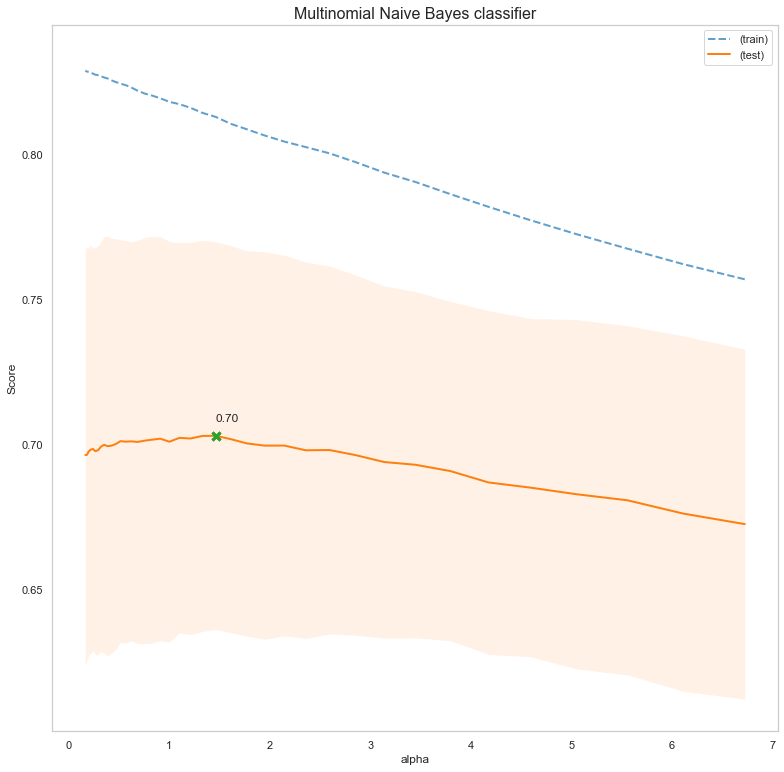

In [16]:
from sklearn.model_selection import GridSearchCV

grid_search_multinomial = GridSearchCV(multinomial, param_grid={'alpha': [1.1 ** (-i) for i in range(-20,20)]}, scoring='f1_macro', return_train_score=True, n_jobs = -1, cv=10)
grid_search_multinomial.fit(X_train, english_train['HS'])

plot_gridsearch(grid_search_multinomial.cv_results_, 'alpha', models[multinomial])

### Bernoulli Naive Bayes classifier

Best alpha: 1.6105100000000006 (0.7257916414512791)


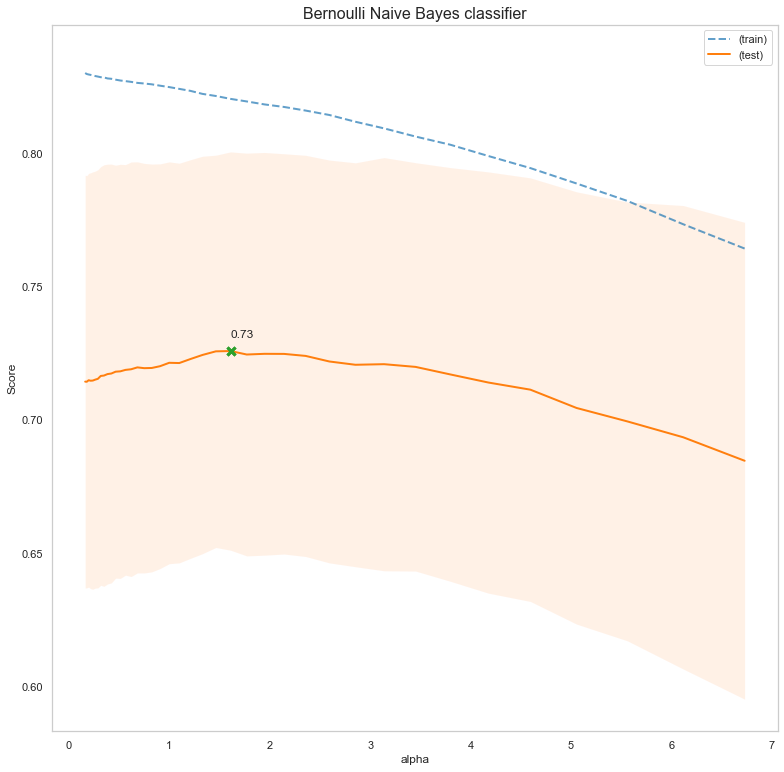

In [19]:
grid_search_bernoulli = GridSearchCV(bernoulli, param_grid={'alpha': [1.1 ** (-i) for i in range(-20,20)]}, scoring='f1_macro', return_train_score=True, n_jobs = -1, cv=10)
grid_search_bernoulli.fit(X_train, english_train['HS'])

plot_gridsearch(grid_search_bernoulli.cv_results_, 'alpha', models[bernoulli])

### Ridge Classifier

Best alpha: 4.594972986357222 (0.7178032859645559)


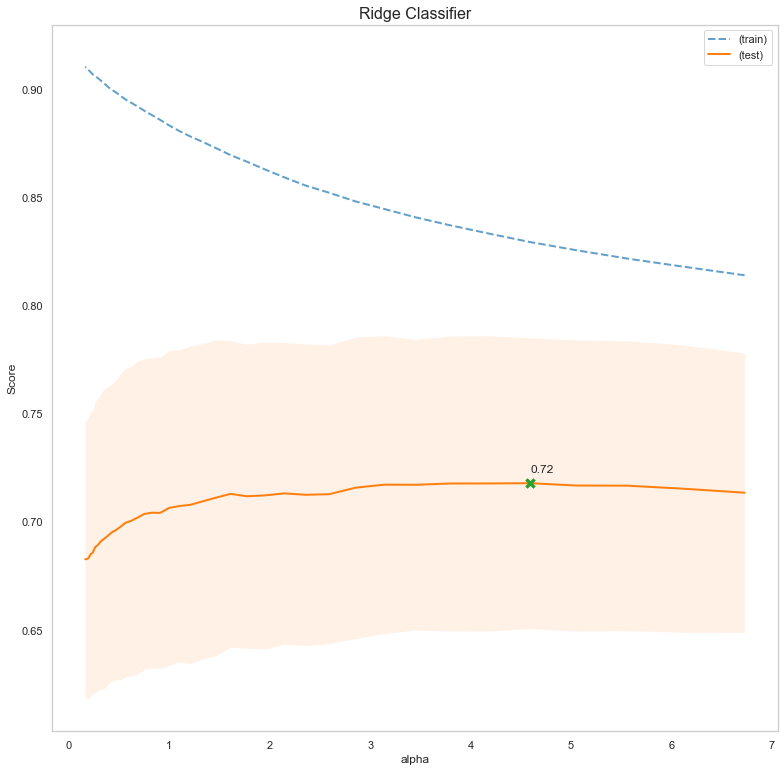

In [20]:
grid_search_ridge = GridSearchCV(ridge, param_grid={'alpha': [1.1 ** (-i) for i in range(-20,20)]}, scoring='f1_macro', return_train_score=True, n_jobs=-1, cv=10)
grid_search_ridge.fit(X_train, english_train['HS'])

plot_gridsearch(grid_search_ridge.cv_results_, 'alpha', models[ridge])

### Random Forest classifier

In [21]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [2 ** (i) for i in range(1,10)] + [None],
    'n_estimators': [2 ** (i) for i in range(1,10)],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}

grid_search_random_forest = GridSearchCV(random_forest,
                  param_grid=param_grid,
                  scoring='f1_macro', return_train_score=True, verbose=1, n_jobs=-1, cv=5)
grid_search_random_forest.fit(X_train, english_train['HS'])

print(grid_search_random_forest.best_params_)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits
{'bootstrap': True, 'max_depth': 256, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 512}


In [22]:
print_grid_search(grid_search_random_forest)

1 {'bootstrap': True, 'max_depth': 256, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 512}
score:  0.7211771061422689 0.9980325117916463
std:  0.08187084155098506 0.0005134463995595155 

2 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 256}
score:  0.72044761855465 0.9982609116809344
std:  0.0796261259988122 0.00031754154690730635 

3 {'bootstrap': True, 'max_depth': 512, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 256}
score:  0.72044761855465 0.9982609116809344
std:  0.0796261259988122 0.00031754154690730635 

4 {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 512}
score:  0.7204397371724452 0.9990021998265055
std:  0.07955299985830881 0.00015620659571933672 

5 {'bootstrap': True, 'max_depth': 512, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 512}
score:  0.7204397371724452 0.9990021998265055
std:  0.07955299985830881 0.000

Fitting 10 folds for each of 42 candidates, totalling 420 fits


C:\Users\BlondeFer\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.72753618 0.72799779 0.72755404 0.7302256  0.72969537 0.72878214
 0.72841067 0.73011699 0.72913017 0.73078005 0.73065794 0.73109594
 0.73399913 0.73418059 0.73607925 0.73397923 0.73584949 0.73470235
 0.73656865 0.73626748 0.73544326 0.73669929 0.73341643 0.73119733
 0.72598107 0.72434664 0.71865583 0.71450503 0.70671673 0.69639988
 0.68612221 0.67615627 0.64423944 0.64423944 0.56441776 0.56441776
 0.56441776 0.56441776 0.56441776 0.56441776        nan        nan]
  category=UserWarning
C:\Users\BlondeFer\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the train scores are non-finite: [0.99793434 0.99787102 0.99778232 0.99787104 0.997833   0.99785831
 0.99792166 0.99787103 0.99783303 0.99783308 0.99794713 0.99797246
 0.99793446 0.9978965  0.99792182 0.9980359  0.99807391 0.99812459
 0.99794697

Best max_features: 0.009223372036854775 (0.7366992862857142)


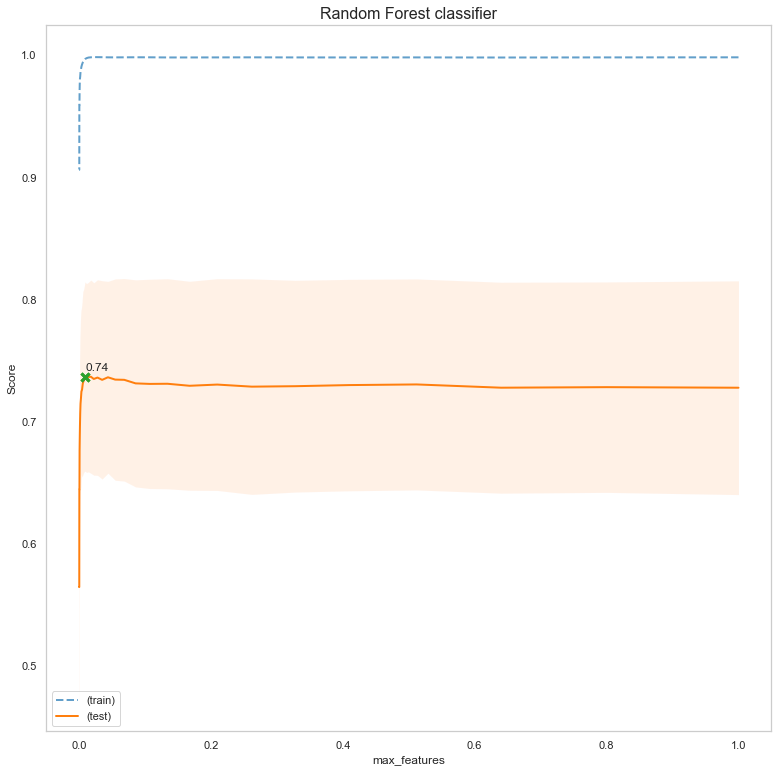

In [29]:
grid_search_random_forest_2 = GridSearchCV(RandomForestClassifier(bootstrap=True, max_depth=256, min_samples_leaf=1, min_samples_split=5, n_estimators=512, random_state=42),
                  param_grid={'max_features': [1.25 ** (-i) for i in range(40)] + [X_train.shape[1] ** 0.5, np.log2(X_train.shape[1])]}, # last two = sqrt and log2
                  scoring='f1_macro', return_train_score=True, verbose=1, n_jobs=-1, cv=10)
 
grid_search_random_forest_2.fit(X_train, english_train['HS'])
plot_gridsearch(grid_search_random_forest_2.cv_results_, 'max_features', models[random_forest])

### Support Vector Classification

In [30]:
param_grid = [{'kernel': ['rbf', 'linear', 'sigmoid'], 'C': [1.25 ** i for i in range(30)]}]

grid_search_svc = GridSearchCV(svc,
                  param_grid=param_grid,
                  scoring='f1_macro', return_train_score=True, verbose=1, n_jobs=-1, cv=10)
grid_search_svc.fit(X_train, english_train['HS'])

print(grid_search_svc.best_params_)

Fitting 10 folds for each of 90 candidates, totalling 900 fits
{'C': 1.25, 'kernel': 'rbf'}


In [31]:
print_grid_search(grid_search_svc)

1 {'C': 1.25, 'kernel': 'rbf'}
score:  0.7256869632572098 0.9774198944245172
std:  0.07028980487619943 0.0012667417379980542 

2 {'C': 1.0, 'kernel': 'linear'}
score:  0.7232218938518609 0.8598128177472508
std:  0.06889058375778051 0.004916139578449366 

3 {'C': 1.0, 'kernel': 'rbf'}
score:  0.722420000756059 0.9584546599227813
std:  0.06598793856917287 0.002093336645136775 

4 {'C': 1.5625, 'kernel': 'rbf'}
score:  0.722399479782383 0.9888443224537624
std:  0.07199664225359012 0.0009368204650846254 

5 {'C': 1.0, 'kernel': 'sigmoid'}
score:  0.7221347437317223 0.8078676840747624
std:  0.0681506862158759 0.0065270911145425626 

6 {'C': 86.73617379884035, 'kernel': 'rbf'}
score:  0.7221273976430322 0.9989863676139541
std:  0.07096146020651312 0.00011337364572931995 

7 {'C': 69.38893903907228, 'kernel': 'rbf'}
score:  0.7221273976430322 0.9989863676139541
std:  0.07096146020651312 0.00011337364572931995 

8 {'C': 169.40658945086008, 'kernel': 'rbf'}
score:  0.7221273976430322 0.99898636

In [32]:
grid_search_svc_2 = GridSearchCV(SVC(C=1.25, kernel='rbf', random_state=42),
                  param_grid={'gamma': [1.25 ** (-i) for i in range(30)] + ['scale', 'auto']},
                  scoring='f1_macro', return_train_score=True, verbose=1, n_jobs = -1, cv=10)
 
grid_search_svc_2.fit(X_train, english_train['HS'])
print(grid_search_svc_2.best_params_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
{'gamma': 1.0}


In [33]:
print_grid_search(grid_search_svc_2)

1 {'gamma': 1.0}
score:  0.7258167249329469 0.9768872942096092
std:  0.07015162428504602 0.0011478902579258189 

2 {'gamma': 'scale'}
score:  0.7256869632572098 0.9774198944245172
std:  0.07028980487619943 0.0012667417379980542 

3 {'gamma': 0.512}
score:  0.7256270521632684 0.9120121046613694
std:  0.0670308196299068 0.0035684427699647866 

4 {'gamma': 0.8}
score:  0.7252856747864351 0.9566877057811034
std:  0.06964197556390557 0.002091927136888322 

5 {'gamma': 0.4096}
score:  0.7251920681535109 0.8891064922596577
std:  0.06542802596203082 0.004197298399689287 

6 {'gamma': 0.64}
score:  0.7239659936641247 0.9341322339556578
std:  0.06760723945339617 0.003783087858440654 

7 {'gamma': 0.32768}
score:  0.721696352447401 0.8691349812109233
std:  0.06654800289044162 0.004734614685150616 

8 {'gamma': 0.262144}
score:  0.7197053739060524 0.8505602228177448
std:  0.06725191719465788 0.005925083728178732 

9 {'gamma': 0.2097152}
score:  0.7174080629610617 0.8349670010798305
std:  0.0664476

### AdaBoost Classifier

In [36]:
param_grid = {'n_estimators': [2 ** (i) for i in range(1,10)],
              'learning_rate': [0.1 * (i) for i in range(5,25)],
              'algorithm': ['SAMME.R']
              }

grid_search_adaboost = GridSearchCV(adaboost,
                  param_grid=param_grid,
                  scoring='f1_macro', return_train_score=True, verbose=1, n_jobs=-1, cv=10)
grid_search_adaboost.fit(X_train, english_train['HS'])

print(grid_search_adaboost.best_params_)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
{'algorithm': 'SAMME.R', 'learning_rate': 0.7000000000000001, 'n_estimators': 256}


In [37]:
print_grid_search(grid_search_adaboost)

1 {'algorithm': 'SAMME.R', 'learning_rate': 0.7000000000000001, 'n_estimators': 256}
score:  0.712632840377788 0.8225154311835787
std:  0.07431863130127009 0.005443977718236347 

2 {'algorithm': 'SAMME.R', 'learning_rate': 0.8, 'n_estimators': 64}
score:  0.7122050882008215 0.772450693631815
std:  0.069500974393686 0.007492901374299629 

3 {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 128}
score:  0.7116679806780868 0.778595058978006
std:  0.06722244161020745 0.007001627564099785 

4 {'algorithm': 'SAMME.R', 'learning_rate': 0.6000000000000001, 'n_estimators': 128}
score:  0.7113469979807773 0.786507603974096
std:  0.06672722747095258 0.005200297834457556 

5 {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 512}
score:  0.7107423269448259 0.8535302723231736
std:  0.07109881685510672 0.005990052574239738 

6 {'algorithm': 'SAMME.R', 'learning_rate': 1.1, 'n_estimators': 64}
score:  0.7106128401735436 0.7770678418857161
std:  0.0744645576842317 0.0080226004

### MLP Classifier

In [17]:
param_grid = {
    'hidden_layer_sizes': [(512, 128, 32), (256, 256, 256), (512, 64), (256, 256), (1024,), (256,)],
    'activation': ['logistic', 'tanh', 'relu'],
}

grid_search_mlp = GridSearchCV(mlp,
                  param_grid=param_grid,
                  scoring='f1_macro', return_train_score=True, verbose=2, n_jobs=-1, cv=10)
grid_search_mlp.fit(X_train, english_train['HS'])

print(grid_search_mlp.best_params_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 39.3min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 47.3min finished


{'activation': 'logistic', 'hidden_layer_sizes': (512, 128, 32)}


In [18]:
print_grid_search(grid_search_mlp)

1 {'activation': 'logistic', 'hidden_layer_sizes': (512, 128, 32)}
score:  0.718382993298716 0.8460031721480291
std:  0.06713930161269371 0.02480298959577832 

2 {'activation': 'relu', 'hidden_layer_sizes': (512, 64)}
score:  0.7169288809003502 0.879979117961833
std:  0.07933498113457435 0.0041029103023282176 

3 {'activation': 'relu', 'hidden_layer_sizes': (256, 256, 256)}
score:  0.7139740368795363 0.8508657637330131
std:  0.07220429799195167 0.036845099371234986 

4 {'activation': 'relu', 'hidden_layer_sizes': (1024,)}
score:  0.7127306752842438 0.8531087366776328
std:  0.07192598029106499 0.03093290619837004 

5 {'activation': 'logistic', 'hidden_layer_sizes': (512, 64)}
score:  0.7118848567415542 0.8458758515718525
std:  0.07888406010718442 0.015987047845431132 

6 {'activation': 'tanh', 'hidden_layer_sizes': (512, 128, 32)}
score:  0.7118232016563286 0.8486536645794113
std:  0.07866574339037274 0.011966381083145133 

7 {'activation': 'tanh', 'hidden_layer_sizes': (256, 256)}
scor

In [19]:
param_grid = {
    'solver': ['adam'],
    'beta_1': [0.9 + 0.025 * i for i in range(-3, 4)],
    'beta_2': [0.999 + 0.00025 * i for i in range(-3, 4)],
    'epsilon': [1e-8 + 25e-10 * i for i in range(-3, 4)]
}

grid_search_mlp_2 = GridSearchCV(MLPClassifier(activation='logistic', hidden_layer_sizes=(512, 128, 32), early_stopping=True, random_state=42),
                  param_grid=param_grid,
                  scoring='f1_macro', return_train_score=True, verbose=2, n_jobs=-1, cv=5)
grid_search_mlp_2.fit(X_train, english_train['HS'])

print(grid_search_mlp_2.best_params_)

Fitting 5 folds for each of 343 candidates, totalling 1715 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 48.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 115.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 216.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 344.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 515.8min
[Parallel(n_jobs=-1)]: Done 1715 out of 1715 | elapsed: 636.4min finished


{'beta_1': 0.875, 'beta_2': 0.99975, 'epsilon': 5e-09, 'solver': 'adam'}


In [20]:
print_grid_search(grid_search_mlp_2)

1 {'beta_1': 0.875, 'beta_2': 0.99975, 'epsilon': 5e-09, 'solver': 'adam'}
score:  0.7060063669510639 0.8396589959329888
std:  0.06061712830006985 0.014195862176696222 

2 {'beta_1': 0.875, 'beta_2': 0.99875, 'epsilon': 1e-08, 'solver': 'adam'}
score:  0.7059735458106069 0.8386175107250015
std:  0.061095089808428 0.013198932931836516 

3 {'beta_1': 0.875, 'beta_2': 0.9985, 'epsilon': 1.25e-08, 'solver': 'adam'}
score:  0.7058894059881171 0.8375222307149819
std:  0.060872326030128515 0.013299767711536197 

4 {'beta_1': 0.9750000000000001, 'beta_2': 0.999, 'epsilon': 1.5000000000000002e-08, 'solver': 'adam'}
score:  0.7055577674237155 0.8369602940839368
std:  0.05549091771553361 0.02553158170021679 

5 {'beta_1': 0.875, 'beta_2': 0.9985, 'epsilon': 1e-08, 'solver': 'adam'}
score:  0.7055374424551338 0.8384077219872175
std:  0.060951873926050046 0.013294981002692746 

6 {'beta_1': 0.875, 'beta_2': 0.99925, 'epsilon': 5e-09, 'solver': 'adam'}
score:  0.7053667509009288 0.8411264643568913
s

In [21]:
import pickle

with open("./data/grid_search_mlp_2.pickle", "wb") as f:
    pickle.dump(grid_search_mlp_2.cv_results_, f)

## Best Models

In [34]:
#Dummy is same
best_multinomial = MultinomialNB(alpha=1.5)
best_bernoulli = BernoulliNB(alpha=1.6)
best_ridge = RidgeClassifier(alpha=4.6, random_state=42)
best_random_forest = RandomForestClassifier(bootstrap=True, max_depth=256, min_samples_leaf=1, min_samples_split=5, n_estimators=512, max_features=0.01, random_state=42)
best_mlp = MLPClassifier(solver='adam', beta_1=0.875, beta_2=0.99975, epsilon=5e-09, activation='logistic', hidden_layer_sizes=(512, 128, 32), early_stopping=True, random_state=42)
best_svc = SVC(C=0.512, kernel='rbf', gamma=0.4, random_state=42)
best_adaboost = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=0.7, n_estimators=256, random_state=42)

best_models = {
    dummy: "Dummy Classifier",
    best_multinomial: "Best Multinomial Naive Bayes classifier",
    best_bernoulli: "Best Bernoulli Naive Bayes classifier",
    best_ridge: "Best Ridge Classifier",
    best_random_forest: "Best Random Forest classifier",
    best_svc: "Best Support Vector Classification",
    best_adaboost: "Best AdaBoost classifier",
    best_mlp: "Best Multi-layer Perceptron classifier"
}
fit_models(X_train, english_train['HS'], best_models)

all_models = {x: y for two_models in zip(models.items(), best_models.items()) for x, y in two_models}

print("\n\nTRAIN:")
all_train_scores, all_train_preds  = print_scores(X_train, english_train["HS"], all_models)

print("\n\nDEV:")
all_dev_scores, all_dev_preds = print_scores(X_dev, english_dev["HS"], all_models)

print("\n\nTEST:")
all_test_scores, all_test_preds = print_scores(X_test, english_test["HS"], all_models)

Model Dummy Classifier fitted
Model Best Multinomial Naive Bayes classifier fitted
Model Best Bernoulli Naive Bayes classifier fitted
Model Best Ridge Classifier fitted
Model Best Random Forest classifier fitted
Model Best Support Vector Classification fitted
Model Best AdaBoost classifier fitted
Model Best Multi-layer Perceptron classifier fitted


TRAIN:
Dummy Classifier

Accuracy:  0.5796666666666667
F1 macro:  0.3669550538088204

Classification Report

               precision    recall  f1-score   support

           0       0.58      1.00      0.73      5217
           1       0.00      0.00      0.00      3783

    accuracy                           0.58      9000
   macro avg       0.29      0.50      0.37      9000
weighted avg       0.34      0.58      0.43      9000

Multinomial Naive Bayes classifier

Accuracy:  0.8204444444444444
F1 macro:  0.8126298508371801

Classification Report

               precision    recall  f1-score   support

           0       0.82      0.88  

C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest classifier

Accuracy:  0.999
F1 macro:  0.9989737648560049

Classification Report

               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5217
           1       1.00      1.00      1.00      3783

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000

Best Random Forest classifier

Accuracy:  0.9966666666666667
F1 macro:  0.9965763219746517

Classification Report

               precision    recall  f1-score   support

           0       0.99      1.00      1.00      5217
           1       1.00      0.99      1.00      3783

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000

Support Vector Classification

Accuracy:  0.9575555555555556
F1 macro:  0.9563093471055895

Classification Report

               pr

C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best Random Forest classifier

Accuracy:  0.758
F1 macro:  0.7506224134804043

Classification Report

               precision    recall  f1-score   support

           0       0.78      0.81      0.79       573
           1       0.73      0.69      0.71       427

    accuracy                           0.76      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.76      0.76      0.76      1000

Support Vector Classification

Accuracy:  0.745
F1 macro:  0.7344853545245258

Classification Report

               precision    recall  f1-score   support

           0       0.75      0.82      0.79       573
           1       0.73      0.64      0.68       427

    accuracy                           0.74      1000
   macro avg       0.74      0.73      0.73      1000
weighted avg       0.74      0.74      0.74      1000

Best Support Vector Classification

Accuracy:  0.728
F1 macro:  0.7069521297684922

Classification Report

               precision    recal

C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ferran\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Dummy Classifier

Accuracy:  0.58
F1 macro:  0.36708860759493667

Classification Report

               precision    recall  f1-score   support

           0       0.58      1.00      0.73      1740
           1       0.00      0.00      0.00      1260

    accuracy                           0.58      3000
   macro avg       0.29      0.50      0.37      3000
weighted avg       0.34      0.58      0.43      3000

Multinomial Naive Bayes classifier

Accuracy:  0.5056666666666667
F1 macro:  0.4784764572972561

Classification Report

               precision    recall  f1-score   support

           0       0.72      0.24      0.36      1740
           1       0.45      0.87      0.60      1260

    accuracy                           0.51      3000
   macro avg       0.59      0.56      0.48      3000
weighted avg       0.61      0.51      0.46      3000

Best Multinomial Naive Bayes classifier

Accuracy:  0.509
F1 macro:  0.48378767377483683

Classification Report

               precisi

In [36]:
for name, y_pred in all_train_preds.iterrows():
    save_results(y_pred, english_train.index, name, "hateval2019/task1", "english", dataset_types.train, group=("best_" if "Best" in name else "") + "traditional", filename="_".join(name.lower().split(" ")))
    
for name, y_pred in all_dev_preds.iterrows():
    save_results(y_pred, english_dev.index, name, "hateval2019/task1", "english", dataset_types.development, group=("best_" if "Best" in name else "") + "traditional", filename="_".join(name.lower().split(" ")))
    
for name, y_pred in all_test_preds.iterrows():
    save_results(y_pred, english_test.index, name, "hateval2019/task1", "english", dataset_types.test, group=("best_" if "Best" in name else "") + "traditional", filename="_".join(name.lower().split(" ")))

Results saved on: ./results/hateval2019/task1/english/train/traditional/dummy_classifier.pkl
Results saved on: ./results/hateval2019/task1/english/train/traditional/multinomial_naive_bayes_classifier.pkl
Results saved on: ./results/hateval2019/task1/english/train/best_traditional/best_multinomial_naive_bayes_classifier.pkl
Results saved on: ./results/hateval2019/task1/english/train/traditional/bernoulli_naive_bayes_classifier.pkl
Results saved on: ./results/hateval2019/task1/english/train/best_traditional/best_bernoulli_naive_bayes_classifier.pkl
Results saved on: ./results/hateval2019/task1/english/train/traditional/ridge_classifier.pkl
Results saved on: ./results/hateval2019/task1/english/train/best_traditional/best_ridge_classifier.pkl
Results saved on: ./results/hateval2019/task1/english/train/traditional/random_forest_classifier.pkl
Results saved on: ./results/hateval2019/task1/english/train/best_traditional/best_random_forest_classifier.pkl
Results saved on: ./results/hateval2019

In [16]:
print("TRAIN:\n", all_train_scores)
print("\n\nDEV:\n", all_dev_scores)
print("\n\nTEST:\n", all_test_scores)

TRAIN:
                                          Accuracy  F1 macro
Dummy Classifier                         0.579667  0.366955
Multinomial Naive Bayes classifier       0.820444  0.812630
Best Multinomial Naive Bayes classifier  0.816222  0.807131
Bernoulli Naive Bayes classifier         0.826000  0.821029
Best Bernoulli Naive Bayes classifier    0.820889  0.815134
Ridge Classifier                         0.881667  0.877431
Best Ridge Classifier                    0.835667  0.827157
Random Forest classifier                 0.999000  0.998974
Best Random Forest classifier            0.996667  0.996576
Support Vector Classification            0.957556  0.956309
Best Support Vector Classification       0.820667  0.807855
AdaBoost classifier                      0.781667  0.767939
Best AdaBoost classifier                 0.824000  0.814896
Multi-layer Perceptron classifier        0.891444  0.888015
Best Multi-layer Perceptron classifier   0.821778  0.817371


DEV:
                         

# BERT

In [19]:
def preprocessing_nn(data):
    return direct_replacement(data.apply(lambda text: re.sub(r"[@#]\w+", "", text)))

X_train_nn = preprocessing_nn(english_train.text)
X_dev_nn = preprocessing_nn(english_dev.text)
X_test_nn = preprocessing_nn(english_test.text)

In [20]:
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss

class AvarageBertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        
        #first_token_tensor = torch.stack(hidden_states[-2:]).mean(0)[:, 0] #Avarage two last CLS layers
        #first_token_tensor = hidden_states[-1][:, -2:].mean(1) #Avarage two last tokens
        first_token_tensor = torch.stack(hidden_states[-2:]).mean(0).mean(1) #Avarage all two last layers

        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

class BertForSequenceClassificationAvarage(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.pooler = AvarageBertPooler(config)

        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, inputs_embeds=None, labels=None, output_attentions=None, output_hidden_states=None, return_dict=None,):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=True,
            return_dict=return_dict,
        )

        pooled_output = self.pooler(outputs[2])
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [21]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

#model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model = BertForSequenceClassificationAvarage.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model.cuda()

#inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
#outputs = model(**inputs)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassificationAvarage: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassificationAvarage from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassificationAvarage from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificationAvarage were not initialized 

BertForSequenceClassificationAvarage(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [22]:
orig_text = english_dev.text.iloc[689]
text = X_dev_nn.iloc[689]

# Print the original sentence.
print(' Original: ', orig_text)
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(orig_text))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(orig_text)))


# Print the original sentence.
print('\n Replaced: ', text)
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(text))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text)))

 Original:  @AliceEvansGruff @cmd51375 @Privacy_Painter @caterita2008 @pat_hardy_ @avaliv_________ @raindovemodel @KSantorri @LizzyBDizzy101 @ggbrokensilence @mae_quez @Jacmalta151 @TakeThatMorals @ClickitH @marczak_rob @elena_audry @VelliniV @snowmancalgary @Lizzie_Borden4 @CIAdaughter @Wiki_Vic @HeltonGreen @Unicorn4Glitter @MeganMia5 @LoveWorksDotCom @aogfx @RealAJBenza @infinity_1616 @Stephanielaz918 @RealpeopleSar @mynameisphaedra @AllenLynching @OrMyLast @Crystal_Ball1 @JoeRipper4 @wtfimontwitr @Bourdain @AsiaArgento @rosemcgowan @LeahMcSweeney @Genxpunk69 @jordanbpeterson "Stop Name Calling" Grow a pair of balls or dont say anything stupid if you know the truth how come you havent released a statement of evidence at all instead of being a arrogant pest. Remember you believe women cant rape men also meaning you think they cant rape women either.
Tokenized:  ['@', 'alice', '##eva', '##ns', '##gr', '##uf', '##f', '@', 'cm', '##d', '##51', '##37', '##5', '@', 'privacy', '_', 'painte

In [23]:
max_len = 0

# For every sentence...
for text in np.hstack([X_train_nn, X_dev_nn, X_test_nn]):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  103


In [24]:
from torch.utils.data import TensorDataset

def tokenize(X, y):

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for text in X:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 128,           # Pad & truncate all sentences.
                            padding='max_length',
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(y.values)

    return input_ids, attention_masks, labels

english_train_bert = TensorDataset(*tokenize(X_train_nn, english_train["HS"]))
english_dev_bert = TensorDataset(*tokenize(X_dev_nn, english_dev["HS"]))

In [25]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            english_train_bert,  # The training samples.
            sampler = RandomSampler(english_train_bert), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            english_dev_bert, # The validation samples.
            sampler = SequentialSampler(english_dev_bert), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [26]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 3, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [27]:
import datetime
import time


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def flat_f1(preds, labels):
    y_pred = np.argmax(preds, axis=1).flatten()
    y_true = labels.flatten()
    return f1_score(y_true, y_pred, average='macro')


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [28]:
import random

# This training code is based on the `run_glue.py` script here:
device = torch.device('cuda:0')

# Set the seed value all over the place to make this reproducible.

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = output.loss
            logits = output.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        total_eval_f1 += flat_f1(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print("  F1 macro: {0:.2f}".format(avg_val_f1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur': avg_val_accuracy,
            'Valid. F1 macro': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    282.    Elapsed: 0:00:20.
  Batch    80  of    282.    Elapsed: 0:00:40.
  Batch   120  of    282.    Elapsed: 0:00:59.
  Batch   160  of    282.    Elapsed: 0:01:19.
  Batch   200  of    282.    Elapsed: 0:01:38.
  Batch   240  of    282.    Elapsed: 0:01:58.
  Batch   280  of    282.    Elapsed: 0:02:17.

  Average training loss: 0.52
  Training epcoh took: 0:02:18

Running Validation...
  Accuracy: 0.75
  F1 macro: 0.74
  Validation Loss: 0.51
  Validation took: 0:00:05

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    282.    Elapsed: 0:00:20.
  Batch    80  of    282.    Elapsed: 0:00:39.
  Batch   120  of    282.    Elapsed: 0:00:59.
  Batch   160  of    282.    Elapsed: 0:01:18.
  Batch   200  of    282.    Elapsed: 0:01:38.
  Batch   240  of    282.    Elapsed: 0:01:58.
  Batch   280  of    282.    Elapsed: 0:02:18.

  Average training loss: 0.36
  Training epcoh took: 0:02:18

Running Validation...
 

In [29]:
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur,Valid. F1 macro,Training Time,Validation Time
epoch,,,,,,
1,0.519567,"tensor(0.5140, device='cuda:0')",0.750000,0.735618,0:02:18,0:00:05
2,0.363085,"tensor(0.5385, device='cuda:0')",0.758789,0.744650,0:02:18,0:00:05
3,0.253620,"tensor(0.5942, device='cuda:0')",0.754883,0.740151,0:02:18,0:00:05


In [48]:
# Option 1
df_stats

,Training Loss,Valid. Loss,Valid. Accur,Valid. F1 macro,Training Time,Validation Time
epoch,,,,,,
1,0.539320,"tensor(0.5223, device='cuda:0')",0.741211,0.726578,0:02:10,0:00:05
2,0.381194,"tensor(0.5204, device='cuda:0')",0.755859,0.737738,0:02:09,0:00:05
3,0.277428,"tensor(0.5827, device='cuda:0')",0.749023,0.735706,0:02:10,0:00:05


In [35]:
# Option 2
df_stats

,Training Loss,Valid. Loss,Valid. Accur,Valid. F1 macro,Training Time,Validation Time
epoch,,,,,,
1,0.726942,"tensor(0.7298, device='cuda:0')",0.421875,0.302375,0:02:18,0:00:05
2,0.726900,"tensor(0.7298, device='cuda:0')",0.421875,0.302375,0:02:17,0:00:05
3,0.726522,"tensor(0.7298, device='cuda:0')",0.421875,0.302375,0:02:15,0:00:05


In [27]:
# Option 3
df_stats

,Training Loss,Valid. Loss,Valid. Accur,Valid. F1 macro,Training Time,Validation Time
epoch,,,,,,
1,0.525420,"tensor(0.5231, device='cuda:0')",0.734375,0.721038,0:02:21,0:00:05
2,0.367693,"tensor(0.5412, device='cuda:0')",0.752930,0.735530,0:02:20,0:00:05
3,0.256406,"tensor(0.6096, device='cuda:0')",0.747070,0.733338,0:02:14,0:00:05


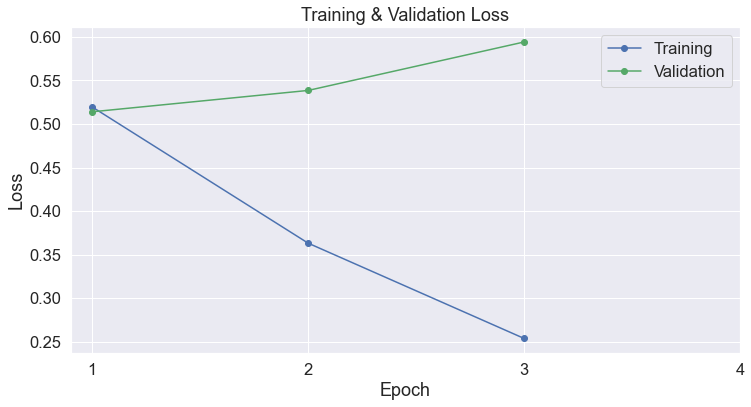

In [30]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [31]:
def evaluate(model, X, y, batch_size=32):
    
    dataset = TensorDataset(*tokenize(X, y))
    
    dataloader = DataLoader(
            dataset, # The validation samples.
            sampler = SequentialSampler(dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions = []

    # Predict 
    for batch in dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Store predictions and true labels
        predictions.append(logits)

    y_pred = np.vstack(predictions).argmax(axis=1)
    print_score(y, y_pred, "BERT")
    
    return y_pred

y_pred_train_bert = evaluate(model, X_train_nn, english_train["HS"])
y_pred_dev_bert = evaluate(model, X_dev_nn, english_dev["HS"])
y_pred_test_bert = evaluate(model, X_test_nn, english_test["HS"])

BERT

Accuracy:  0.9372222222222222
F1 macro:  0.9358185007280024

Classification Report

               precision    recall  f1-score   support

           0       0.95      0.94      0.95      5217
           1       0.91      0.94      0.93      3783

    accuracy                           0.94      9000
   macro avg       0.93      0.94      0.94      9000
weighted avg       0.94      0.94      0.94      9000

BERT

Accuracy:  0.755
F1 macro:  0.7534613522997025

Classification Report

               precision    recall  f1-score   support

           0       0.82      0.73      0.77       573
           1       0.68      0.79      0.73       427

    accuracy                           0.76      1000
   macro avg       0.75      0.76      0.75      1000
weighted avg       0.76      0.76      0.76      1000

BERT

Accuracy:  0.594
F1 macro:  0.580508982434646

Classification Report

               precision    recall  f1-score   support

           0       0.86      0.36      0.51  

In [32]:
description = """Pretrained model with bert-base-uncased checkpoint (12 layers). Trained 3 epochs with a batch size of 32 and using AdamW optimizer with lr=2e-5 and eps=1e-8.
Hastags and user have been removed from input text, followed by the same procedure as in method direct_replacement().
Bert Pooler layer is modified to use the avarage of the last 2 layers instead of just [CLS]."""

save_results(y_pred_train_bert, english_train.index, "Bert Avarage", "hateval2019/task1", "english", dataset_types.train, group="deep_learning", filename="bert-avarage-2layers", description=description)
save_results(y_pred_dev_bert, english_dev.index, "Bert Avarage", "hateval2019/task1", "english", dataset_types.development, group="deep_learning", filename="bert-avarage-2layers", description=description)
save_results(y_pred_test_bert, english_test.index, "Bert Avarage", "hateval2019/task1", "english", dataset_types.test, group="deep_learning", filename="bert-avarage-2layers", description=description)

Results saved on: ./results/hateval2019/task1/english/train/deep_learning/bert-avarage-2layers.pkl
Results saved on: ./results/hateval2019/task1/english/development/deep_learning/bert-avarage-2layers.pkl
Results saved on: ./results/hateval2019/task1/english/test/deep_learning/bert-avarage-2layers.pkl


# GPT-2

In [10]:
def preprocessing_gpt2(data):
    return direct_replacement(data.apply(lambda text: re.sub(r"@\w+", "user", text)).apply(lambda text: re.sub(r"#\w+", "hashtag", text)).apply(lambda text: re.sub(r"https?\S*", "link", text)))

X_train_gpt2 = preprocessing_gpt2(english_train.text)
X_dev_gpt2 = preprocessing_gpt2(english_dev.text)
X_test_gpt2 = preprocessing_gpt2(english_test.text)

In [11]:
from transformers import GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification
import torch

print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained('gpt2', num_labels=2)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained('gpt2', config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

model.cuda()

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
      

In [12]:
max_len = 0

# For every sentence...
for text in np.hstack([X_train_gpt2, X_dev_gpt2, X_test_gpt2]):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  119


In [13]:
from torch.utils.data import TensorDataset

def tokenize(X, y):

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for text in X:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            #add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 128,           # Pad & truncate all sentences.
                            padding='max_length',
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(y.values)

    return input_ids, attention_masks, labels

english_train_gpt2 = TensorDataset(*tokenize(X_train_gpt2, english_train["HS"]))
english_dev_gpt2 = TensorDataset(*tokenize(X_dev_gpt2, english_dev["HS"]))

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            english_train_gpt2,  # The training samples.
            sampler = RandomSampler(english_train_gpt2), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            english_dev_gpt2, # The validation samples.
            sampler = SequentialSampler(english_dev_gpt2), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 3, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [16]:
import datetime
import time


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def flat_f1(preds, labels):
    y_pred = np.argmax(preds, axis=1).flatten()
    y_true = labels.flatten()
    return f1_score(y_true, y_pred, average='macro')


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [17]:
import random

# This training code is based on the `run_glue.py` script here:
device = torch.device('cuda:0')

# Set the seed value all over the place to make this reproducible.

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = output.loss
        logits = output.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = output.loss
            logits = output.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
        total_eval_f1 += flat_f1(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print("  F1 macro: {0:.2f}".format(avg_val_f1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur': avg_val_accuracy,
            'Valid. F1 macro': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    563.    Elapsed: 0:00:13.
  Batch    80  of    563.    Elapsed: 0:00:26.
  Batch   120  of    563.    Elapsed: 0:00:40.
  Batch   160  of    563.    Elapsed: 0:00:53.
  Batch   200  of    563.    Elapsed: 0:01:06.
  Batch   240  of    563.    Elapsed: 0:01:20.
  Batch   280  of    563.    Elapsed: 0:01:33.
  Batch   320  of    563.    Elapsed: 0:01:47.
  Batch   360  of    563.    Elapsed: 0:02:01.
  Batch   400  of    563.    Elapsed: 0:02:14.
  Batch   440  of    563.    Elapsed: 0:02:28.
  Batch   480  of    563.    Elapsed: 0:02:41.
  Batch   520  of    563.    Elapsed: 0:02:55.
  Batch   560  of    563.    Elapsed: 0:03:09.

  Average training loss: 0.64
  Training epcoh took: 0:03:09

Running Validation...
  Accuracy: 0.67
  F1 macro: 0.64
  Validation Loss: 0.60
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    563.    Elapsed: 0:00:14.
  Batch    80  of    563.    Elapsed: 0

In [18]:
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur,Valid. F1 macro,Training Time,Validation Time
epoch,,,,,,
1,0.637969,"tensor(0.5971, device='cuda:0')",0.671627,0.638828,0:03:09,0:00:06
2,0.532790,"tensor(0.5712, device='cuda:0')",0.718254,0.674243,0:03:11,0:00:06
3,0.479172,"tensor(0.5392, device='cuda:0')",0.719246,0.697801,0:03:12,0:00:06
4,0.450724,"tensor(0.5188, device='cuda:0')",0.736111,0.710797,0:03:10,0:00:06


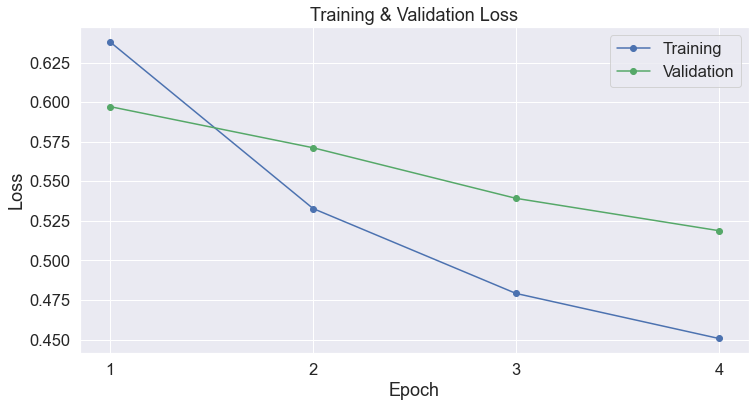

In [19]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [20]:
def evaluate(model, X, y, batch_size=32):
    
    dataset = TensorDataset(*tokenize(X, y))
    
    dataloader = DataLoader(
            dataset, # The validation samples.
            sampler = SequentialSampler(dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions = []

    # Predict 
    for batch in dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Store predictions and true labels
        predictions.append(logits)

    y_pred = np.vstack(predictions).argmax(axis=1)
    print_score(y, y_pred, "GPT 2")
    
    return y_pred

y_pred_train_gpt2 = evaluate(model, X_train_gpt2, english_train["HS"], batch_size)
y_pred_dev_gpt2 = evaluate(model, X_dev_gpt2, english_dev["HS"], batch_size)
y_pred_test_gpt2 = evaluate(model, X_test_gpt2, english_test["HS"], batch_size)

GPT 2

Accuracy:  0.8097777777777778
F1 macro:  0.8041471883706952

Classification Report

               precision    recall  f1-score   support

           0       0.83      0.84      0.84      5217
           1       0.78      0.76      0.77      3783

    accuracy                           0.81      9000
   macro avg       0.81      0.80      0.80      9000
weighted avg       0.81      0.81      0.81      9000

GPT 2

Accuracy:  0.738
F1 macro:  0.733062728221179

Classification Report

               precision    recall  f1-score   support

           0       0.78      0.76      0.77       573
           1       0.69      0.70      0.70       427

    accuracy                           0.74      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.74      0.74      0.74      1000

GPT 2

Accuracy:  0.5043333333333333
F1 macro:  0.4611797590564015

Classification Report

               precision    recall  f1-score   support

           0       0.81      

In [21]:
description = """Pretrained model with gpt2 checkpoint (12 layers). Trained 4 epochs with a batch size of 16 and using AdamW optimizer with lr=2e-5 and eps=1e-8.
Hastags, users and links have been replaced with a word from input text, followed by the same procedure as in method direct_replacement()."""

save_results(y_pred_train_gpt2, english_train.index, "GPT2 base", "hateval2019/task1", "english", dataset_types.train, group="deep_learning", filename="gpt2", description=description)
save_results(y_pred_dev_gpt2, english_dev.index, "GPT2 base", "hateval2019/task1", "english", dataset_types.development, group="deep_learning", filename="gpt2", description=description)
save_results(y_pred_test_gpt2, english_test.index, "GPT2 base", "hateval2019/task1", "english", dataset_types.test, group="deep_learning", filename="gpt2", description=description)

Results saved on: ./results/hateval2019/task1/english/train/deep_learning/gpt2.pkl
Results saved on: ./results/hateval2019/task1/english/development/deep_learning/gpt2.pkl
Results saved on: ./results/hateval2019/task1/english/test/deep_learning/gpt2.pkl


# Atalaya

In [13]:
import tensorflow_hub as hub
import tensorflow as tf

elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

def ELMoEmbedding(input_text):
    return elmo(tf.reshape(tf.cast(input_text, tf.string), [-1]), signature="default", as_dict=True)["elmo"]

In [14]:
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout, LSTM, Concatenate
from tensorflow.keras.models import Model

def build_model():
    # biLSTM-ELMo
    input_layer_elmo = Input(shape=(1,), dtype="string")
    embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer_elmo)
    BiLSTM = Bidirectional(LSTM(128, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
    Dense_layer_1 = Dense(64, activation='relu')(BiLSTM)
    Dropout_layer_1 = Dropout(0.45)(Dense_layer_1)
    
    # BoW
    input_layer_bow = Input(shape=(3500,), dtype=np.float32)
    Dense_layer_2 = Dense(512, activation='relu')(input_layer_bow)
    Dropout_layer_2 = Dropout(0.2)(Dense_layer_2)
    Dense_layer_3 = Dense(64, activation='relu')(Dropout_layer_2)
    Dropout_layer_3 = Dropout(0.45)(Dense_layer_3)
    
    concatenate_layer = Concatenate()([Dropout_layer_1, Dropout_layer_3])
    output_layer = Dense(1, activation='sigmoid')(concatenate_layer)
    
    model = Model(inputs=[input_layer_elmo, input_layer_bow], outputs=output_layer, name="Atalaya")
    model.summary()
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=tf.keras.optimizers.Adam(learning_rate=35e-5, decay=0.01), metrics=['accuracy'])
    return model
elmo_BiDirectional_model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "Atalaya"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3500)]       0                                            
__________________________________________________________________________________________________
Elmo_Embedding (Lambda)         (None, None, 1024)   0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          1792512     input_2[0][0]                    
____________________________________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
from tensorflow.python.keras import backend as K
import random

with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer()) 
    session.run(tf.tables_initializer())
    
    random.seed(seed_val)
    np.random.seed(seed_val)
    tf.random.set_random_seed(seed_val)
    
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)
    model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("atalaya.h5", save_best_only=True)
    callbacks = [early_stopping_cb, model_checkpoint_cb]
    
    
    model_elmo = elmo_BiDirectional_model.fit([X_train_nn, X_train], english_train["HS"], epochs=25,
                                            shuffle=True, batch_size=64, validation_data=([X_dev_nn, X_dev], english_dev["HS"]),
                                            callbacks = callbacks)
    
    train_prediction = elmo_BiDirectional_model.predict([X_train_nn, X_train]) >= 0.5
    dev_prediction = elmo_BiDirectional_model.predict([X_dev_nn, X_dev]) >= 0.5
    test_prediction = elmo_BiDirectional_model.predict([X_test_nn, X_test]) >= 0.5
    
    print_score(english_train["HS"], train_prediction, "Atalya Train")
    print_score(english_dev["HS"], dev_prediction, "Atalya Dev")
    print_score(english_test["HS"], test_prediction, "Atalya Test")

Train on 9000 samples, validate on 1000 samples
Epoch 1/25
9000/9000 [==============================] - 63s 7ms/sample - loss: 0.6099 - acc: 0.6633 - val_loss: 0.5787 - val_acc: 0.6850
Epoch 2/25
9000/9000 [==============================] - 55s 6ms/sample - loss: 0.5228 - acc: 0.7407 - val_loss: 0.5454 - val_acc: 0.7030
Epoch 3/25
9000/9000 [==============================] - 55s 6ms/sample - loss: 0.4650 - acc: 0.7876 - val_loss: 0.5295 - val_acc: 0.7170
Epoch 4/25
9000/9000 [==============================] - 55s 6ms/sample - loss: 0.4262 - acc: 0.8140 - val_loss: 0.5218 - val_acc: 0.7340
Epoch 5/25
9000/9000 [==============================] - 54s 6ms/sample - loss: 0.3920 - acc: 0.8362 - val_loss: 0.5208 - val_acc: 0.7290
Epoch 6/25
9000/9000 [==============================] - 55s 6ms/sample - loss: 0.3713 - acc: 0.8474 - val_loss: 0.5145 - val_acc: 0.7380
Epoch 7/25
9000/9000 [==============================] - 54s 6ms/sample - loss: 0.3504 - acc: 0.8591 - val_loss: 0.5151 - val_acc: 

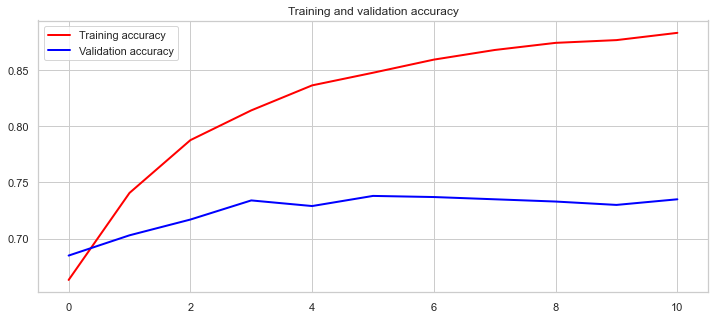

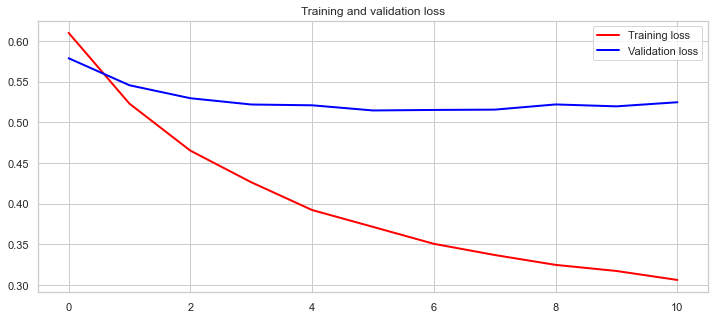

In [16]:
accuracy = model_elmo.history['acc']
val_accuracy = model_elmo.history['val_acc']
loss = model_elmo.history['loss']
val_loss = model_elmo.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
import pickle5 as pickle

# Replacament of module pickle for pickle5, to allow python < 3.8.3 to run.
pd.io.pickle.pickle = pickle

description = """Reproduction of architecture that the Atalaya. Following the architecture of two inputs:
- Input text is converted into Elmo embeding, followed by a BiLSTM with dropout and a layer composed of a dense and a dropout sublayer.
- BoW embeding, followed by two layers of a dense and a dropout sublayer.
All model architectural and optimizer parameters are the same as the specified on the paper."""

save_results(train_prediction[:,0], english_train.index, "Atalaya", "hateval2019/task1", "english", dataset_types.train, group="deep_learning", filename="atalaya", description=description)
save_results(dev_prediction[:,0], english_dev.index, "Atalaya", "hateval2019/task1", "english", dataset_types.development, group="deep_learning", filename="atalaya", description=description)
save_results(test_prediction[:,0], english_test.index, "Atalaya", "hateval2019/task1", "english", dataset_types.test, group="deep_learning", filename="atalaya", description=description)

Results saved on: ./results/hateval2019/task1/english/train/deep_learning/atalaya.pkl
Results saved on: ./results/hateval2019/task1/english/development/deep_learning/atalaya.pkl
Results saved on: ./results/hateval2019/task1/english/test/deep_learning/atalaya.pkl
